<p align='center'>
<h1> Amazon Fine Food Reviews  </h1>

Project for <i>text mining and search</i> course, master's degree in Data Science (A.Y. 2021/2022)

Authors:

* Ranieri Silvia | 878067 | s.ranieri7@campus.unimib.it
* Confalonieri Riccardo | 830404 | r.confalonieri5@campus.unimib.it
</p>

<p align='justify'>
The data used for the project are strongly based on the text and numerical evaluation (score) of the reviews. Specifically the data used was downloaded from <a href='https://www.kaggle.com/snap/amazon-fine-food-reviews'> kaggle</a> and consists of reviews of fine foods from amazon. The features present in our dataset are:

* ProductId. Unique identifier for the product.
* UserId. Unique identifier for the user.
* ProfileName. Profile name of the user.
* HelpfulnessNumerator. Number of users who found the review helpful.
* HelpfulnessDenumerator. Number of users who indicated whether they found the review helpful or not.
* Score. Rating assigned to the review between $1$ and $5$.
* Time. Review date in UNIX format.
* Summary. Brief summary of the review.
* Text. Text of the review.

The objective is to predict, given the text, the score (binary and / or real) assigned to the review with supervised <i>classification models</i>. Then we want to try to divide the texts into groups that represent the topics dealt with or the different scores assigned by <i>clustering models</i>. 
In the end, we also tried to approach <i>topic modeling</i> to extract the arguments from the reviews. 
</p>

# Import packages
<p align='justify'>
In this section we import all the necessarly packages for this notebook.
</p>

In [ ]:
!pip install -q pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 1.6 MB/s 


In [ ]:
# Read csv and work with dataframe
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
# Deal with timestamp to date conversion
from datetime import datetime
# for plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Handling regular expression
import re
# for count element in list
from collections import Mapping
from collections import Counter

# packages for TEXT PREPROCESSING
import unicodedata # library for removing letters accents 
import nltk # for removing stopwords 
from nltk.corpus import stopwords # for removing stopwords 
nltk.download('stopwords') # download standartd stopwords 
from nltk.tokenize import word_tokenize # for tokenization
nltk.download('punkt') # for removing punctuation
from nltk.stem.porter import PorterStemmer # for stemming

# packages for TEXT REPRESENTATION
from sklearn.feature_extraction.text import CountVectorizer # BOW
from sklearn.feature_extraction.text import TfidfVectorizer # Tf-Idf
from sklearn.decomposition import TruncatedSVD # for dimensionality reduction

# packages for EVALUATION
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics.cluster import normalized_mutual_info_score

# packages for CLASSIFICATION
from sklearn import metrics
from sklearn.model_selection import train_test_split # for splitting data
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression #logreg
from sklearn.kernel_approximation import RBFSampler # for an approximate version of SVM
from sklearn.linear_model import SGDClassifier # for an approximate version of SVM
# packages for CLASSIFICATION with neural networks
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM
from tensorflow.keras.utils import to_categorical

# packages for CLUSTERING
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing # for standardize data
from sklearn.cluster import KMeans # kmeans clustering
from sklearn.cluster import AgglomerativeClustering # hierarchical clustering
from sklearn.metrics import (rand_score, adjusted_mutual_info_score,
                             homogeneity_score, completeness_score,
                             v_measure_score, fowlkes_mallows_score,
                             silhouette_score)

# packages for display wordcloud
import math
from wordcloud import WordCloud


# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
# removing warnings (we have warnings only for pyLDAvis)
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
# NOTE: if you run this locally please do NOT execute!!! 
# just set the variable drive_path to the local path

# mounting Google Drive folder
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_path = '/content/drive/MyDrive/TM_Project/'

Mounted at /content/drive


# Data loading and inspection
<p align='justify'>
Loading and analysis our data.
</p>

In [ ]:
# loading csv file with amazon reviews from drive
df_reviews = pd.read_csv(drive_path + 'Data/Reviews.csv', sep = ',', index_col = ['Id']) 
df_reviews.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# extracting first and last reviews date
first_rev = df_reviews[df_reviews['Time'] == df_reviews['Time'].min()]['Time'].squeeze()
last_rev = df_reviews[df_reviews['Time'] == df_reviews['Time'].max()]['Time'].squeeze()

# print some statistical information
print('Dataset contains:', df_reviews.shape[0], 'reviews')
print('Dataset contains:', df_reviews.shape[1], 'features')
print('Number of active users:', len(df_reviews['UserId'].unique()))
print('Number of reviews products:', len(df_reviews['ProductId'].unique()))
print('Score between: [{},{}]'.format(df_reviews['Score'].min(), df_reviews['Score'].max()))
print('Average score: {}'.format(round(df_reviews['Score'].mean(),2)))
print('Date of first review:', datetime.fromtimestamp(first_rev))
print('Date of last review:', datetime.fromtimestamp(last_rev.values[0]))

Dataset contains: 568454 reviews
Dataset contains: 9 features
Number of active users: 256059
Number of reviews products: 74258
Score between: [1,5]
Average score: 4.18
Date of first review: 1999-10-08 00:00:00
Date of last review: 2012-10-26 00:00:00


<p align='justify'>
From the statistics displayed we can see that in the dataset there are over $200$k users and over $74$k products. Furthermore, the data refers to a time period of 13 years, this could be a problem as it could have changed the way users vote and/or write reviews. This temporal aspect will be analyzed in more detail in the following subsections. 

## Duplicate data detection
<p align='justify'>
Checking if there are any repeated reviews in the dataframe, repeated reviews are those made by the <i>same user and same product</i>. We want to delete updated reviews, <i>keeping only the most recent ones</i>. First of all we sort all the reviews based on timestamp, we want the oldest ones to be the latest in the dataframe. In this way every time we find a duplicate row we can eliminate it because it will be older than the previous ones.
</p>

In [ ]:
# sorting reviews
df_reviews.sort_values(by=['Time'], inplace = True, ascending=False)

# save tot. rows for statistics
total_rows = df_reviews.shape[0]

# removing duplicate rows keep only the first occurence
df_reviews.drop_duplicates(subset=['ProductId', 'UserId'], keep='first', inplace = True)

<p align='justify'>
We can see that there is <i>another problem</i> with this dataframe, some reviews have the same text, rating and date but different product code. This can be due to many factors such as different sellers or amazon policies, however since the text and the rating are the same it was decided to <i>delete them anyway because they would not add useful data for the classification</i> (same features). It was considered that it is difficult for a consumer to buy several identical products at the same time from different sellers, so it is reasonable to believe that it is precisely the same review that is automatically duplicated. 
</p>

In [ ]:
# example case of duplicated reviews
df_reviews[df_reviews['UserId'] == 'AZYMD9P9F9UZ6']

# link amazon of two of this products
# https://www.amazon.com/Jack-Links-Premium-Steak-Sweet/dp/B000GW46DE
# https://www.amazon.com/Jack-Links-Premium-Steak-Original/dp/B000GW6786?th=1 

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
88656,B000PMJLJO,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
35393,B000GW46D4,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
415855,B000GW6786,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
353122,B000PMC7GI,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
201316,B000GW46DE,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
183035,B000PMHLZK,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...


In [ ]:
# deleting this new type of duplicated rows, in this case it is indifferent if we keep first or last occurence
df_reviews.drop_duplicates(subset=['UserId', 'Score', 'Time', 'Text'], keep='first', inplace = True)

remaining_rows = df_reviews.shape[0]
removed_rows = total_rows-remaining_rows
print("No. of rows removed:", removed_rows)
print("Remaining rows:", remaining_rows)

print(f"\nPercentage of data removed: {np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed: 175485
Remaining rows: 392969

Percentage of data removed: 30.87%
Percentage of data remaining: 69.13%


## Missing data detection
<p align='justify'>
Due to the fact the text (maybe summary) and score columns are essential for the next steps we make sure that they do not contain null data.
</p>

In [ ]:
# visualizing missing data count
df_reviews[['Score', 'Summary', 'Text']].isnull().sum().to_frame(name='# of missing values')

,# of missing values
Score,0
Summary,3
Text,0


<p align='justify'>
As we can see from the following report missing data are only in the summary column but the corresponding text column is fill correctly. So we just convert this null values to empty string.
</p>

In [ ]:
# checking null rows problem
df_reviews[df_reviews['Summary'].isnull()]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
392530,B001H9XOEW,A22R17YPXEULEZ,Liz Wong,0,0,3,1334534400,NaN,I like the product and tried it before I pucha...
237566,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,1328572800,NaN,This is a cool system only problem is that the...
360783,B00020HHHC,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...


In [ ]:
# filling na values
df_reviews["Summary"] = df_reviews["Summary"].fillna('')

## Check score column
<p align='justify'>
We have already check that score column contain only values from $1$ to $5$, now we check the frequency of each score.
</p>

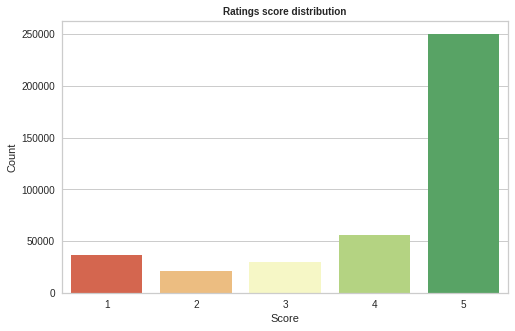

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x = 'Score', data = df_reviews, palette=sns.color_palette("RdYlGn", 5))

plt.title("Ratings score distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.show();

<p align='justify'>
From the plot it is evident that the score class is <b>highly imbalanced</b>, this <i>must be treated correctly</i> before using this data as a training set for our tasks.
</p>

## Time shifting analysis
<p align='justify'>
As anticipated before in this section we will analyze how the reviews are divise during years and we inspect some text in order to see if it could be a problem for the next tasks.
</p>

In [ ]:
# converting time column to datatime format
df_reviews["Time"] = pd.to_datetime(df_reviews.Time,  unit='s')
df_reviews.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
14784,B000S859NC,A2H7STZ2URUCOE,"Christopher Whedon ""the odd bead""",0,0,5,2012-10-26,GREAT TEA,Rooibos Natural Red tea is something of a pers...
440486,B002ZOCEMG,A1LIP0F4R542OQ,A,0,0,1,2012-10-26,:(,I just got this coffee a few days ago. I had c...
535437,B001EO5RSQ,A33W5JAFGHYRQZ,"ghermine ""ghermine""",0,0,5,2012-10-26,Love this Cereal!,There is nothing else like this on the market....
7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,1,2012-10-26,Don't like the taste,I do not like sour taste and this has a sour k...
146095,B000SDKDM4,A18NG9I9MT2V8I,"Emm ""Emm""",0,0,5,2012-10-26,Deeeee-lish!,For far too long I was a devotee of the Starbu...


In [ ]:
pd.DatetimeIndex(df_reviews["Time"]).year.value_counts().sort_values().to_frame(name='# of reviews')

,# of reviews
1999,4
2001,8
2000,17
2002,32
2003,99
2004,440
2005,1061
2006,4705
2007,15696
2008,22994


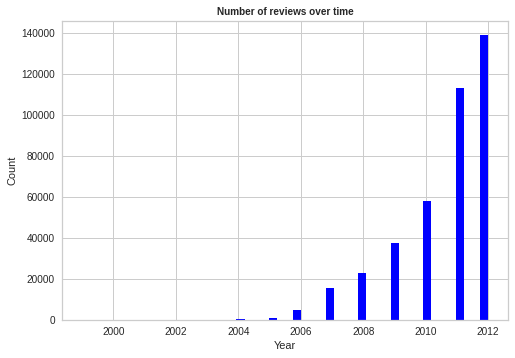

In [ ]:
# plottig number of reviews overtime
plt.hist(df_reviews["Time"].dt.year, bins=50, color='blue')
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Number of reviews over time', fontweight='bold', fontsize=10)
plt.show()

<p aling='align'>
We can see from either from the printed dataframe or from the plot that during years has been recorded an exponential growth of reviews, this was an expected behavior. Let's now focus on 1999 reviews.
</p>

In [ ]:
# extracting only rows with time.year = 1999
df_1999 = df_reviews[df_reviews['Time'].dt.year == 1999]

# visualize all text
for _, row in df_1999.iterrows():
  print(row['Text'] + '\n')

A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.

Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the 

<p align='justify'>
By focusing on this texts we can see that are quite similar to more recent reviews, this is also valid for the other years in the dataset. So we can consider valid this oldest reviews and try to use also them in our tasks.
</p>

## Statistics on reviews
<p align='justify'>
Now we analyze some statistics about the number of reviews per product, user and time.
</p>

In [ ]:
df_prod_count = df_reviews['ProductId'].value_counts()
df_prod_count.to_frame(name = '# of reviews per product')

,# of reviews per product
B007JFMH8M,913
B003B3OOPA,622
B001EO5Q64,566
B000NMJWZO,542
B006MONQMC,491
...,...
B0069N36N0,1
B005X4AJ9K,1
B0085YAR4C,1
B0047S8WFQ,1


Number of products with more than 500 reviews: 4 




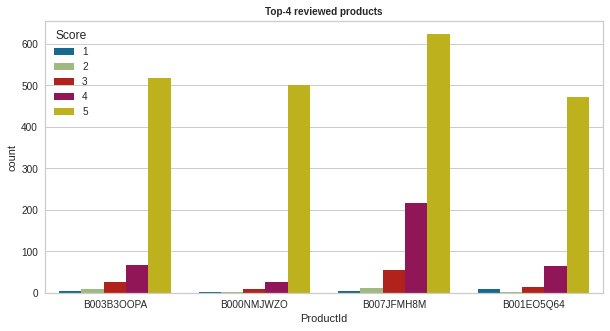

In [ ]:
# extracting from complete df only the 4 top reviewed products
df_top4 = df_reviews[df_reviews['ProductId'].isin(list(df_prod_count[df_prod_count >= 500].index))]

print('Number of products with more than 500 reviews:', len(df_prod_count[df_prod_count >= 500]), '\n\n')

plt.figure(figsize=(10,5))
sns.countplot(x="ProductId",  hue="Score", data=df_top4);
plt.title('Top-4 reviewed products', fontweight='bold', fontsize=10)
plt.show()

<p align='justify'>
From the plot we can see that all the fourth product has very good reviews, with the product 'B007JFMH8M' that has the highest number of 5-star score. <br>
Due to the fact that <i>our analysis will consider only the text</i> of the review and not the userid or the productid the fact that some product has very more huge number of reviews than other products it will <i>not be a problem</i>. The same can be observed for the number of reviews gaven from a single user as you can see below.
</p>

In [ ]:
df_prod_count = df_reviews['UserId'].value_counts()
df_prod_count.to_frame(name = '# of reviews per user')

,# of reviews per user
AY12DBB0U420B,327
A3OXHLG6DIBRW8,274
A281NPSIMI1C2R,249
A1Z54EM24Y40LL,211
A1YUL9PCJR3JTY,197
...,...
A2FSAXNS71EYOR,1
A3NVFBUJ6R5LFS,1
A2TVVRD9LCSED1,1
A3GL43VRUS7HP5,1


The last statistics we want to observe is the number of reviews during time.

In [ ]:
# creating a new column with only year-month as time
df_reviews['time_ym'] = df_reviews['Time'].map(lambda x: x.strftime('%Y-%m'))


# Divide the data by score
grp_s1=df_reviews[df_reviews['Score']==1]
grp_s2=df_reviews[df_reviews['Score']==2]
grp_s3=df_reviews[df_reviews['Score']==3]
grp_s4=df_reviews[df_reviews['Score']==4]
grp_s5=df_reviews[df_reviews['Score']==5]

# grouping data for each month
grp_date_1=grp_s1.groupby(by=['time_ym']).count();
grp_date_2=grp_s2.groupby(by=['time_ym']).count();
grp_date_3=grp_s3.groupby(by=['time_ym']).count();
grp_date_4=grp_s4.groupby(by=['time_ym']).count();
grp_date_5=grp_s5.groupby(by=['time_ym']).count();

# reset index
grp_date_1.reset_index(inplace=True);
grp_date_2.reset_index(inplace=True);
grp_date_3.reset_index(inplace=True);
grp_date_4.reset_index(inplace=True);
grp_date_5.reset_index(inplace=True);

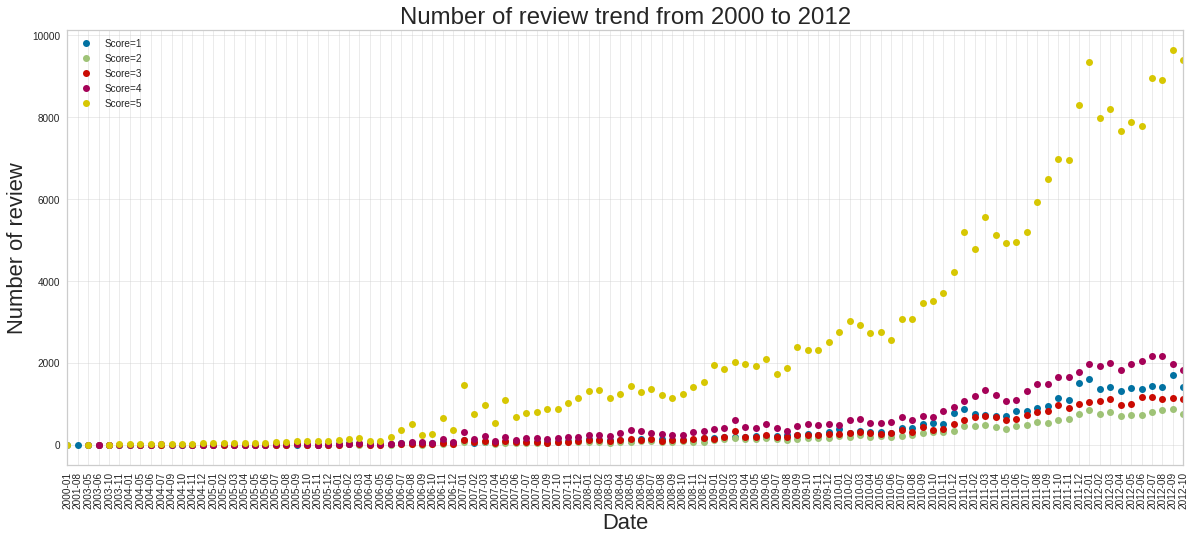

In [ ]:
# review count by score for each month from 2000 to 2012
plt.figure(figsize=(20,8))

plt.plot_date(x=grp_date_1['time_ym'],y=grp_date_1['Score'],label='Score=1');
plt.plot_date(x=grp_date_2['time_ym'],y=grp_date_2['Score'],label='Score=2');
plt.plot_date(x=grp_date_3['time_ym'],y=grp_date_3['Score'],label='Score=3');
plt.plot_date(x=grp_date_4['time_ym'],y=grp_date_4['Score'],label='Score=4');
plt.plot_date(x=grp_date_5['time_ym'],y=grp_date_5['Score'],label='Score=5');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2000-01','2012-10');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Number of review trend from 2000 to 2012',fontsize=24);
#grp_date

<p align='justify'>
We can see that from 2000 to 2006 the reviews available on Amazon are limited, probably because there weren't many users on this platform. The trend starts to grow after 2006, the total number of <i>5-star reviews shows the greatest growth among all scores</i>, this seems unusual and one might wonder that people are generally optimistic or most likely there are <i>unverified accounts</i> that are increasing the seller inappropriately with fake reviews as happened in recent years (for example recently amazon has banned over 600 companies for this very reason)!!
On the other hand the <i>1 to 4 star review count gradual increase</i> make more sense due to more customer become aware of Amazon services.
</p>

## Cleaning dataframe
<p align='justify'>
The dataframe contains some columns that we not use in the next steps so we delete it from the dataframe for simplicity.

In [ ]:
# For simplicity we delete not useful columns (we will not consider them for our analysis)
df_reviews.drop(['ProductId', 'UserId', 'Time', 'ProfileName', 'time_ym',
                 'HelpfulnessNumerator', 'Summary', 'HelpfulnessDenominator'], 
                axis = 1, inplace = True)

# resetting index to [0,n]
df_reviews.reset_index(drop=True, inplace=True)

df_reviews.head()

,Score,Text
0,5,Rooibos Natural Red tea is something of a pers...
1,1,I just got this coffee a few days ago. I had c...
2,5,There is nothing else like this on the market....
3,1,I do not like sour taste and this has a sour k...
4,5,For far too long I was a devotee of the Starbu...


In [ ]:
# removing data from memory to save space
del grp_date_1, grp_date_2, grp_date_3, grp_date_4, grp_date_5, grp_s1, grp_s2
del grp_s3, grp_s4, grp_s5, df_1999, df_prod_count, df_top4, first_rev, row
del removed_rows, total_rows, remaining_rows, last_rev 

# Text pre-processing *: 
<p align='justify'>
The aim of this section is to prepare data for the following analysis by pre-processing correctly the text associated with each reviews.
</p>

## Normalization *
<p aling='justify'>
Normalization is the first pre-processing phase we are considering because usually packages for stop-words removal and stemming/lemmatization are based on a pre-defined set of words. Never the less this set of words is usually in lowercase fold and also does not consider strange accents that maybe some user can add in is reviews. <br>
So starting from this consideration we will apply:

1. Lowercase to each text
2. Abbreviation replacement. 
3. Accent replacement.

We have decided to apply abbreviation replacements because we want to <b>preserve the word 'not'</b> because it could be very important for qualifying correctly binary reviews (positive vs negative). Since there is not a predefine dictionary to expand common abbreviation we decide to focus only to the most common form of abbreviating 'not'.

In [ ]:
# Function to expand common english abbreviation, focus on 'not' case.
# Thanks to: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(phrase):
    # specific for not
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general not cases
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'t", " not", phrase)

    # general
    # phrase = re.sub(r"\'re", " are", phrase)
    # phrase = re.sub(r"\'s", " is", phrase)
    # phrase = re.sub(r"\'d", " would", phrase)
    # phrase = re.sub(r"\'ll", " will", phrase)
    # phrase = re.sub(r"\'ve", " have", phrase)
    # phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# function to replace accents with normal letter (e.g ù -> u, ò -> o)
# thanks to: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def accents_replace(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


# defining a function for concatenate all the normalization steps
# in this way we can easily apply this function to all rows of a dataframe
def normalization(unnormalized_text):
  # 1. converting text to lowercase
  lowercase_text = unnormalized_text.lower()
  # 2. replacement abbreviation (we want to preserve all the words, e.g. don't -> do not)
  decontracted_text = decontracted(lowercase_text)
  # 3. replacement accents with normal letters
  normalized_text =  accents_replace(decontracted_text)

  return normalized_text

In [ ]:
print("<-------- Before normalization -------->")
print(df_reviews.loc[3]['Text'], '\n\n')

print("<-------- After normalization -------->")
# apply normalization step
df_reviews['Text'] = df_reviews['Text'].apply(normalization)
# print out the result
print(df_reviews.loc[3]['Text'])

<-------- Before normalization -------->
I do not like sour taste and this has a sour kind of taste which i don't like. The smell isn't that great either 


<-------- After normalization -------->
i do not like sour taste and this has a sour kind of taste which i do not like. the smell is not that great either


<p align='justify'>
As we can see from in the example the word 'not' has been correctly expanend, all the string is now lowercase and without accents. Unfortunatelly if we inspect more carefully the dataset, as reported in the next cell, we can see that there are <i>other problems</i>: 

* presence of URLs and/or HTML tags
* presence of URLs written in text format such as: www(dot)francescorinaldi(dot)com
* presence of textual emojis (e.g. :) )
* presence of multi spaces. 
* presence of numbers and puntuactions

So we need to treat them properly before going on. 
</p>

In [ ]:
print('Example of multi white spaces and emoij:', df_reviews.loc[3890]['Text'])
print('\nExample of URLs presence:', df_reviews.loc[70]['Text'])
print('\nExample of underscore presence:', df_reviews.loc[2413]['Text'])

Example of multi white spaces and emoij: i was a little leary after only using big brands, but i could not pass up the awesome deal.  so glad i tried :)  this vanilla syrup is yummy.

Example of URLs presence: i just love it, and i am not a major indian cooking fan--just enough. really, it mixes with anything you are doing like <a href="http://www.amazon.com/gp/product/b000fixt2i">steamed brown rice bowl, organic, microwaveable, 7.4-ounce bowls (pack of 12)</a> (i use these for convenience, and then i do not eat the whole pot of rice). in many kinds of soups, etc. beef it up with some <a href="http://www.amazon.com/gp/product/b001fa1klw">amore tomato paste, 4.5-ounce tubes (pack of 12)</a>, which is so, so convenient. sweeten to taste if you prefer. here's the best artificial sweetener on amazon <a href="http://www.amazon.com/gp/product/b0019lth3u">nunaturals nustevia alcohol free stevia glass bottle liquid, 2-ounce</a>. (stop using splenda which contains three chlorine moities. it's e

## Extra problems removal
<p align='justify'>
This is not a mandatory part but it is needed for our specific dataset. In particular we remove HTML tags, url, emoji, spaces, number and punctuation.
</p>

In [ ]:
# to be sure I just define a regex also for standard smartphone emoij
emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
      u"\U0001F1F2-\U0001F1F4"  # Macau flag
      u"\U0001F1E6-\U0001F1FF"  # flags
      u"\U0001F600-\U0001F64F"
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u"\U0001F1F2"
      u"\U0001F1F4"
      u"\U0001F620"
      u"\u200d"
      u"\u2640-\u2642"
      "]+", flags=re.UNICODE)

# Define more common ascii old-school emoij
lst_ascii_emoji = [":(", ":)", ":-(", ":-)", "0:)", "0:-)", "8-)", ':")', ":$", ":'(", ":')", 
 ":'-(", ":'-)", ":'-D", ":'D", ":(", ":)", ":*)", ":,'(", ":,'-(", ":,(", ":,)",
 ":,-(", ":,-)", ":,-D", ":,D", ':-")', ":-$", ":-(", ":-)", ":-*", ":-/", ":-@",
 ":-D", ":-o", ":-O", ":-P", ":-S", ":-Z", ":-|", ":/", ":@", ":D", ":o", ":O",
 ":P", ":s", ":z", ":|", ";(", ";)", ";-(", ";-)", "]:)", "]:-)", "B-)", "o:)",
 "O:)", "O:-)", "o:-)", "X-)", "x-)", ": )", ": ("
]

In [ ]:
# function to remove html tags
def remove_tags(phrase):
  # remove html tag by regex
  return re.sub(r"<[^<]+?>", '', phrase)
  # alternative using beautifulsoup
  # BeautifulSoup(phrase, "lxml").text


# function to remove url
def url_removal(phrase):
  # removing all possibile URLs bu regex
  phrase = re.sub(r"http\S+", '', phrase)
  # removing text URLs that end with .it
  phrase = re.sub(r"www.[\S]+?it", '', phrase)
  # removing text URLs that end with .com and return
  return re.sub(r"www.[\S]+?com", '', phrase)


# function to remove multi spaces/tabs
def multi_space_removal(phrase):
  # remove multi space
  phrase = re.sub("\s\s+", " ", phrase)
  # remove start/end space and return
  return phrase.strip()

# function to remove textual emoij
def emoij_removal(phrase):
  # removing visual emoij
  phrase =  re.sub(emoji_pattern, '', phrase)
  # removing ascii emoij
  for emoij in lst_ascii_emoji:
    phrase = phrase.replace(emoij, '')
  return phrase

# function to remove punctuation
def remove_num_symb(phrase):
  # remove punctuation
  phrase = re.sub('[^\w\s]',' ', phrase)
  # remove dot  
  phrase = re.sub('\.', ' ', phrase)
  # remove underscore
  phrase = re.sub('_', ' ', phrase)
  # remove number
  phrase = re.sub('\d+',' ', phrase)
  
  return phrase 


def extra_removal(phrase):
  # removing html tags
  phrase = remove_tags(phrase)
  # removing url
  phrase = url_removal(phrase)
  # removing emoij
  phrase = emoij_removal(phrase)
  # removing number and puntuaction
  phrase = remove_num_symb(phrase)
  # removing multi space and return 
  return multi_space_removal(phrase)

In [ ]:
print("<-------- Before cleaning -------->")
print('Example1: ', df_reviews.loc[3890]['Text'])
print('Example2: ', df_reviews.loc[70]['Text'], '\n\n')

print("<-------- After cleaning -------->")
# apply extra removal step
df_reviews['Text'] = df_reviews['Text'].apply(extra_removal)
# print out the result
print('Example1: ', df_reviews.loc[3890]['Text'])
print('Example2: ', df_reviews.loc[70]['Text'])

<-------- Before cleaning -------->
Example1:  i was a little leary after only using big brands, but i could not pass up the awesome deal.  so glad i tried :)  this vanilla syrup is yummy.
Example2:  i just love it, and i am not a major indian cooking fan--just enough. really, it mixes with anything you are doing like <a href="http://www.amazon.com/gp/product/b000fixt2i">steamed brown rice bowl, organic, microwaveable, 7.4-ounce bowls (pack of 12)</a> (i use these for convenience, and then i do not eat the whole pot of rice). in many kinds of soups, etc. beef it up with some <a href="http://www.amazon.com/gp/product/b001fa1klw">amore tomato paste, 4.5-ounce tubes (pack of 12)</a>, which is so, so convenient. sweeten to taste if you prefer. here's the best artificial sweetener on amazon <a href="http://www.amazon.com/gp/product/b0019lth3u">nunaturals nustevia alcohol free stevia glass bottle liquid, 2-ounce</a>. (stop using splenda which contains three chlorine moities. it's essentially

<p align='justify'>
After this further cleaning, no <i>further particular cases of this dataset</i> are noticed. We then proceed with the removal of all stopwords except the 'not' as anticipated.
</p>

## Stop words removal *
<p align='justify'>
For removing stopwords we just use the default english list provided by the nltk package. We just <i>add two terms related to this specific context</i>: amazon and product 
</p>

In [ ]:
# function to remove stopwords
def stopword_removal(phrase, lst_stopwords):
  return ' '.join([word for word in phrase.split() if word not in lst_stopwords])

In [ ]:
# retrieving english stopwords
lst_stopwords = stopwords.words('english')

# removing 'not' from the list
lst_stopwords.remove('not')
# remove also would, is not in the list
lst_stopwords.append('would')
# Adding two specific words for our context that we want to remove
lst_stopwords.append('product')
lst_stopwords.append('amazon')

# Apply and print stopwords removal
print("<-------- Before remove stopwords -------->")
print('Example1: ', df_reviews.loc[3890]['Text'])
print('Example2: ', df_reviews.loc[70]['Text'], '\n\n')

print("<-------- After remove stopwords -------->")
# apply stopwords removal
df_reviews['Text'] = df_reviews['Text'].apply(lambda x: stopword_removal(x, lst_stopwords))
# print out the result
print('Example1: ', df_reviews.loc[3890]['Text'])
print('Example2: ', df_reviews.loc[70]['Text'])

<-------- Before remove stopwords -------->
Example1:  i was a little leary after only using big brands but i could not pass up the awesome deal so glad i tried this vanilla syrup is yummy
Example2:  i just love it and i am not a major indian cooking fan just enough really it mixes with anything you are doing like steamed brown rice bowl organic microwaveable ounce bowls pack of i use these for convenience and then i do not eat the whole pot of rice in many kinds of soups etc beef it up with some amore tomato paste ounce tubes pack of which is so so convenient sweeten to taste if you prefer here s the best artificial sweetener on amazon nunaturals nustevia alcohol free stevia glass bottle liquid ounce stop using splenda which contains three chlorine moities it s essentially bleach folks enjoy lentils are so healthy and this way they really have flavor fyi this costs per pack at our local stores when you can find it it is not overpriced as someone here said 


<-------- After remove sto

<p align='justify'>
We can se that useless words has been removed, but 'not' has been preserved. 
</p>

## Tokenization *
<p align='justify'>
At this point we have correctly cleaned up the sentences, we will therefore proceed with the tokenization of the remaining words.
</p>

In [ ]:
# applying ntlk word_tokenize method
df_reviews['Token_Text'] = df_reviews['Text'].apply(word_tokenize) 
# inspect first 3 rows for checking results
df_reviews[['Text', 'Token_Text']].head(3)

,Text,Token_Text
0,rooibos natural red tea something personal tas...,"[rooibos, natural, red, tea, something, person..."
1,got coffee days ago coffee bean yesterday toda...,"[got, coffee, days, ago, coffee, bean, yesterd..."
2,nothing else like market gmo highest fiber cer...,"[nothing, else, like, market, gmo, highest, fi..."


## Stemming *
<p align='justify'>
Once texts have been correctly tokenized, we apply the porter stemming technique.
</p>

In [ ]:
# define porter stemmer with default NLTK_EXTENSIONS. It is an improvement of standard porter
porter = PorterStemmer()

# function to apply stemmatization on a token list. It works with nltk stemmer that
# provide the stem() method
def stemSentence(token_words, stemmer):
  # empty list for support
  stem_text=[]
  # stemming each token in the list
  for word in token_words:
    stem_text.append(stemmer.stem(word))
    
  return stem_text

In [ ]:
# Stemming all the row in the dataset
df_reviews['Stem_Text'] = df_reviews['Token_Text'].apply(lambda x: stemSentence(x, porter))

df_reviews.head(3)

,Score,Text,Token_Text,Stem_Text
0,5,rooibos natural red tea something personal tas...,"[rooibos, natural, red, tea, something, person...","[rooibo, natur, red, tea, someth, person, tast..."
1,1,got coffee days ago coffee bean yesterday toda...,"[got, coffee, days, ago, coffee, bean, yesterd...","[got, coffe, day, ago, coffe, bean, yesterday,..."
2,5,nothing else like market gmo highest fiber cer...,"[nothing, else, like, market, gmo, highest, fi...","[noth, els, like, market, gmo, highest, fiber,..."


# Prepare data
<p align='justify'>
Since it was decided to apply a <b>binary classification</b> to our data it is necessary to apply some further transformations to the dataset: 

1. Delete all columns with a netral score (score equal to $3$).
2. Convert the remaining scores into two different class <i>positive</i> (score $4$ or $5$) and negative (score $1$ or $2$). For simplicity, these two classes will be <i>represented in a binary way</i> so the positive class will be indicated with $1$ and the negative class with $0$.

This score conversion could not be the optimal one but is an approximate and proxy way of determining the polarity (positivity/negativity) of a review. After this steps we split our data into training and test set, in this way we can test appropriately our models.


<b> Disclaimer: </b> Since we are splitting our data only <i> after pre-processing steps</i>, the test set is already prepared as the training set. Otherwise it will be necessarly to apply the same steps done before to test set!
</p> 

In [ ]:
# Create a copy for working without loosing the real data
df_copy = df_reviews[['Score', 'Text', 'Stem_Text']]

In [ ]:
# removing all rows with score = 3
df_copy = df_copy[df_copy['Score'] != 3]

# given a numerical score return two different string based on the score
def target_column(x):
  return 1 if x>3 else 0 if x<3 else 2

# apply function
df_copy['Target_score'] = df_copy['Score'].apply(target_column)
# check result
df_copy[['Score','Target_score']].head()

,Score,Target_score
0,5,1
1,1,0
2,5,1
3,1,0
4,5,1


In [ ]:
# splitting data into training and test. We keep 20% of rows as test set
X_train, X_test, y_train, y_test = train_test_split(df_copy['Stem_Text'], 
                                                    df_copy['Target_score'], 
                                                    test_size=0.20,
                                                    random_state=39, 
                                                    stratify=df_copy['Target_score'])

## Handling score imbalance
<p align='justify'>
As we have seen in the <a href='https://colab.research.google.com/drive/1iIKoL_tKGtk5oyRVS5qg2P-eLCUTSaNx?authuser=1#scrollTo=UKxwf0Q6CMl-&line=3&uniqifier=1'> first section of this notebook </a> the score class is highly unbalanced, so we check if this problem is also present after splitting (sure) and we apply some techniques to overcome this problem. <br>
This is a problem only for training data due to the fact that in test set we want to preserve the unbalance because in this way we can simulate what it will happens in a real situation and so get a real score of our models.
</p>


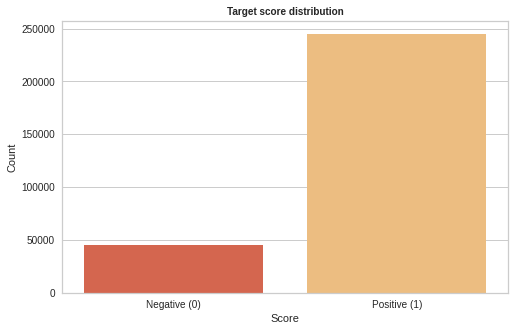

In [ ]:
# Checking if also y_train is unbalanced
plt.figure(figsize=(8,5))
sns.countplot(x = y_train, palette=sns.color_palette("RdYlGn", 5))

plt.title("Target score distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(np.arange(0,2,1), ['Negative (0)', 'Positive (1)'])
plt.show();

### Downsampling majority class
<p align='justify'>
Since the positive class contains more and more data than the other we decide to downsample it to the same size of the negative ones. This is not the only techniques that could be applied, for example we can do data augmentation for the negative class. 
</p>

In [ ]:
# append the target column to x_train dataset, to simplify resizing 
# they will split again later
df_temp = pd.concat([X_train, y_train], axis = 1)

# extract sample for each target class
negative = df_temp.loc[df_temp['Target_score'] == 0] # 45633
positive = df_temp.loc[df_temp['Target_score'] == 1].sample(negative.shape[0], random_state = 83)

data = pd.concat([positive, negative])
data = shuffle(data, random_state = 43)

X_train = data['Stem_Text']
y_train = data['Target_score']

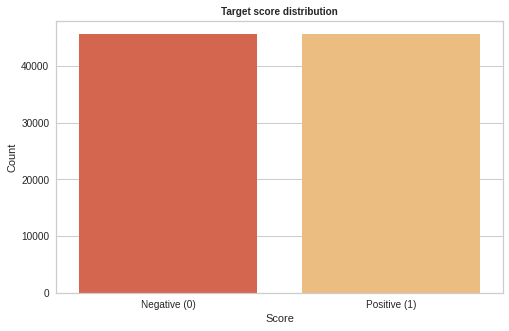

In [ ]:
# Checking if also y_train is unbalanced
plt.figure(figsize=(8,5))
sns.countplot(x = y_train, palette=sns.color_palette("RdYlGn", 5))

plt.title("Target score distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(np.arange(0,2,1), ['Negative (0)', 'Positive (1)'])
plt.show();

<p align='justify'>
We can see that now the two class has the same number of sample in the training set.
</p>

# Text representation *:
<p align='justify'>
First of all we analize the length of the sentences to understand if there are  very big difference.
</p>

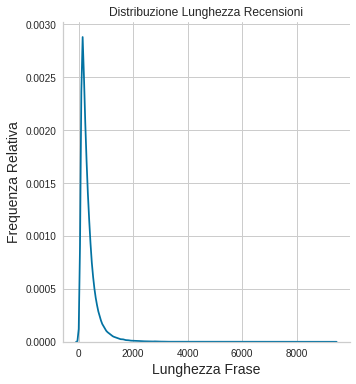

In [ ]:
sns.displot([len(s) for s in X_train], kind='kde')
plt.title('Distribuzione Lunghezza Recensioni')
plt.ylabel("Frequenza Relativa", size = 14)
plt.xlabel("Lunghezza Frase", size = 14)
plt.show()

<p align='justify'>
We can observe that the most sentences has more or less the same length, so also a simplest method such as bag of words could be considered for text representation. We start to try with the following method for representation:

- Bag of words
- Tf-idf

By considering the tf-idf techniques we are also considering the document lenght, for what we have just said about length we do not expect such a different results in classification. 
</p>

## Bag of words (BOW)
<p align='justify'>
We apply the bag of words text representation on training set. We also save the fitted BOW models for applying the same one on the test set in order to perform evaluations on that. <br>
<b>Note</b> that in this case we are not using the binary version of bow but we are actually counting the number of occurrences 
</p>

In [ ]:
# fitting bag of words on X_train
vect_bow = CountVectorizer(min_df = 5).fit(X_train.astype(str))

# visualizing first 15 terms in bow
print("some sample features (unique words in the corpus):",vect_bow.get_feature_names_out()[0:15])

some sample features (unique words in the corpus): ['aa' 'aaa' 'aacut' 'aafco' 'ab' 'aback' 'abandon' 'abbey' 'abc' 'abdomen'
 'abdomin' 'aberr' 'abhor' 'abid' 'abil']


<p align='justify'>
We can see that there are some wrong words like 'aa' that of course are not preprocessing well. Is therefore possible to add more rules to deal with letters repetition, at least when it happens at the beginning or at the end of the word. The problem is that this is strictly english dependent and also it can causes errors for words that legitimately start or end with repeated letters such as 'see', 'zoo' 'all', etc... So we decided not to modify the preprocessing phase.
</p>

In [ ]:
# applying bow transformation on train set
X_train_bow = vect_bow.transform(X_train.astype(str))

# check bow results
X_train_bow

<91266x12135 sparse matrix of type '<class 'numpy.int64'>'
	with 2913659 stored elements in Compressed Sparse Row format>

In [ ]:
print('Min value in bow matrix:', X_train_bow.min())
print('Max value in bow matrix:', X_train_bow.max())

Min value in bow matrix: 0
Max value in bow matrix: 59


<p aling='justify'>
We can see that now we have a sparse matrix, this is expected after the application of BOW because not all document (single reviews in this case) contains all possible words in our vocabulary. And as expected the max value is not $1$ because we count the number of occurence!
</p>

## TF-IDF
<p align='justify'>
We also prepare the tf-idf text representation on the same train set, in this way we can compare the scores obtained with different representation techniques. As before we save the fitted tf-idf for applyed it after on test set.
</p>

In [ ]:
# saving fitted tf-idf
vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_train.astype(str))

# visualizing first 15 terms in bow
print("some sample features (unique words in the corpus): ",vect_tfidf.get_feature_names_out()[0:15])

some sample features (unique words in the corpus):  ['aa' 'aaa' 'aacut' 'aafco' 'ab' 'aback' 'abandon' 'abbey' 'abc' 'abdomen'
 'abdomin' 'aberr' 'abhor' 'abid' 'abil']


In [ ]:
# apply it on training set
X_train_tfidf = vect_tfidf.transform(X_train.astype(str))

# check results
X_train_tfidf

<91266x12135 sparse matrix of type '<class 'numpy.float64'>'
	with 2913659 stored elements in Compressed Sparse Row format>

In [ ]:
print("The number of unique words", X_train_tfidf.shape[1])
print('Min value in tf-idf matrix:', X_train_tfidf.min())
print('Max value in tf-idf matrix:', X_train_tfidf.max())

The number of unique words 12135
Min value in tf-idf matrix: 0.0
Max value in tf-idf matrix: 0.9988690821123125


<p align='justify'>
As before the output is a sparse matrix, because not all words in our vocabulary are in each reviews. But now we can see that the max value is normalized.

# Dimensionality reduction
<p align='justify'>
The representations extracted with bow and tf-idf contain a very high number of features, this requires high resources and computational times to be able to classify and cluster the data. For this reason we apply the <i>Truncated SVD</i> techniques to reduce the number of features, we apply this tecnhique because is the most suitable ones for working with sparse matrix. In doing so we try to maximize the number of features by keeping more ore less $75\%$ of explained variance.
</p>

In [ ]:
# fitting truncated SVD on training set
svd_bow = TruncatedSVD(n_components=600).fit(X_train_bow)

print('Bow explained variance:', svd_bow.explained_variance_ratio_.sum())

# applying SVD to X_train
X_train_bow = svd_bow.transform(X_train_bow)

Bow explained variance: 0.7565332909312276


<p align='justify'>
We do the same process for tf-idf training data, in this case we need to significantly increase the number of components to preserve the same explained variance as in bow.
</p>

In [ ]:
# fitting truncated SVD on training set
svd_tfidf = TruncatedSVD(n_components=1500).fit(X_train_tfidf)

print('Tf-idf explained variance:', svd_tfidf.explained_variance_ratio_.sum())

# applying SVD to X_train
X_train_tfidf = svd_tfidf.transform(X_train_tfidf)

Tf-idf explained variance: 0.7377447985978409


# Classification task *
<p aling='justify'>
As mentioned previously, we want to classify reviews into two macro categories: positive (1) or negative (0). So it is a <b> binary classification</b>! We do this with different classification algorithms and we compare each results for bow and tf-idf representation methods.
</p>

In [ ]:
# defining some usefull methods to evaluate performance

# function to make and evaluate prediction given a classifier, a set of features and real labels
def evaluate_prediction(clf, features, y_hat, t_names = ['Negative', 'Positive']):
  # predicting label for test set, using features extracted before
  y_pred = clf.predict(features)
  y_pred = np.round(y_pred)
  # print report
  print(classification_report(y_pred, y_hat, target_names=t_names))

  # get confusion matrix
  cm = confusion_matrix(y_pred, y_hat)

  # plot beautiful confusion matrix
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu");  

  ax.set_xticklabels(t_names)
  ax.set_yticklabels(t_names)
  ax.set_xlabel('True labels'); 
  ax.set_ylabel('Predicted labels'); 
  ax.set_title('Confusion Matrix'); 

  return y_pred

# plot roc curve (not for svm)
def plot_roc(clf, X, y):
  #define metrics
  y_pred_proba = clf.predict_proba(X)[::,1]
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
  auc = metrics.roc_auc_score(y_test, y_pred_proba)

  #create ROC curve
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()

# function to visualize top discriminative features for class positive and negative.
# thanks to: https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
# not for lightlgb
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

## Logistic regression
<p align='justify'>
The first classifier we want to test is the logistic regression model. As said before we apply this classifier first on bag of words representation and then we use the same classifier on TF-IDF to see if there is some difference.
</p>

### BOW
<p align='justify'>
We apply logistic regression model with BOWs representation.
</p>

In [ ]:
%%time
# ----------- BOW -----------
# instantiate logistic regression method
logreg_bow = LogisticRegression()
# fitting model on training data for bow
logreg_bow = logreg_bow.fit(X_train_bow, y_train)

print('<---------------- BOW parameters ---------------->')
print('Logistic regression intercept for bow:', logreg_bow.intercept_)
# only print first 10 coefficients
print('Logistic regression first 10 coefficients for bow:', logreg_bow.coef_[0][0:10], '\n\n')

<---------------- BOW parameters ---------------->
Logistic regression intercept for bow: [-0.1632382]
Logistic regression first 10 coefficients for bow: [-0.16738983  0.3477117   0.23718637  1.07238463 -0.64197554  0.93229826
  0.29941751  0.018624    0.24749926 -0.29590302] 


CPU times: user 13.7 s, sys: 1.22 s, total: 14.9 s
Wall time: 7.9 s


              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87     45467
    Positive       0.87      0.86      0.87     45799

    accuracy                           0.87     91266
   macro avg       0.87      0.87      0.87     91266
weighted avg       0.87      0.87      0.87     91266



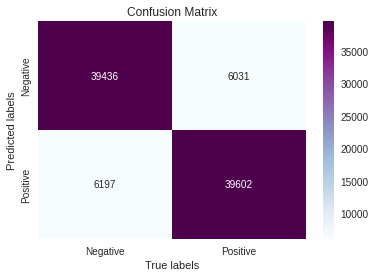

In [ ]:
# get score on training set
_ = evaluate_prediction(logreg_bow, X_train_bow, y_train)

              precision    recall  f1-score   support

    Negative       0.86      0.54      0.67     18078
    Positive       0.87      0.97      0.92     54571

    accuracy                           0.86     72649
   macro avg       0.86      0.76      0.79     72649
weighted avg       0.86      0.86      0.85     72649



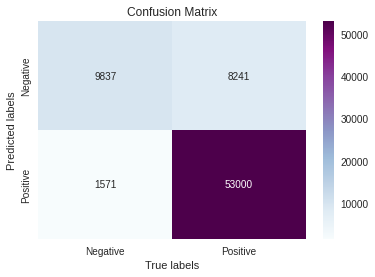

In [ ]:
# apply same bow trasformation to test set
X_test_bow = vect_bow.transform(X_test.astype(str))
# apply same dimensionality reduction to test set
X_test_bow = svd_bow.transform(X_test_bow)

# evaluate prediction on TEST set
y_pred_logreg_bow = evaluate_prediction(logreg_bow, X_test_bow, y_test)

<p align='justify'>
We can see that the classifier is overfitting the training data for the negative reviews class. In particular the precision metrics is good for both the two class while the recall is not very good for the negative class, in fact we have some <i>positive reviews that are misclassified.</i> <br>
From the following report we can also see that the most informative features for classifie positive and negative reviews are not so simple to interpret and do not carry very simple words like good and bad.
</p>

In [ ]:
show_most_informative_features(vect_bow, logreg_bow)

	-1.8676	abl            		1.2743	antisept       
	-1.5903	advertis       		1.2472	acut           
	-1.4381	abhor          		1.1295	aesthet        
	-1.2205	abund          		1.1274	achiev         
	-1.0414	apiec          		1.0715	aafco          
	-0.9961	apex           		1.0427	aggrav         
	-0.9757	arginin        		1.0349	abid           
	-0.9682	acidophilu     		1.0152	adventuresom   
	-0.9650	accessori      		1.0073	anti           
	-0.9465	apart          		0.9997	alik           
	-0.9286	appet          		0.9401	aerogarden     
	-0.9209	ambul          		0.9266	aback          
	-0.9126	antidot        		0.9168	absinth        
	-0.8698	asterisk       		0.9008	adren          
	-0.8614	answer         		0.9005	antibacteri    
	-0.8258	ag             		0.8992	asia           
	-0.8253	articul        		0.8992	access         
	-0.8188	addit          		0.8824	anybodi        
	-0.8113	ak             		0.8792	acet           
	-0.7958	agress         		0.8602	appropri       


### TF-IDF
<p align='justify'>
Now we try to perform the same task by using the TF-IDF representation.
</p>

In [ ]:
%%time
# ----------- TF-IDF -----------
# instantiate logistic regression method
logreg_tfidf = LogisticRegression()
# fitting model on training data for bow
logreg_tfidf = logreg_tfidf.fit(X_train_tfidf, y_train)

print('<---------------- TF-IDF parameters ---------------->')
print('Logistic regression intercept for bow:', logreg_tfidf.intercept_)
# only print first 10 coefficients
print('Logistic regression first 10 coefficients for bow:', logreg_tfidf.coef_[0][0:10], '\n\n')

<---------------- TF-IDF parameters ---------------->
Logistic regression intercept for bow: [-0.46975337]
Logistic regression first 10 coefficients for bow: [ 2.2900445   1.42776959  2.10347421  4.89516878  0.1491423  37.23407687
 -1.98041444  0.09837778  0.69672456  2.46475729] 


CPU times: user 34.3 s, sys: 4.07 s, total: 38.4 s
Wall time: 30.2 s


              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     45955
    Positive       0.88      0.89      0.89     45311

    accuracy                           0.89     91266
   macro avg       0.89      0.89      0.89     91266
weighted avg       0.89      0.89      0.89     91266



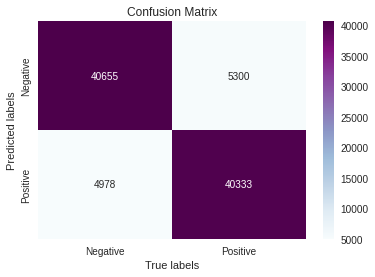

In [ ]:
# get score on training set
_ = evaluate_prediction(logreg_tfidf, X_train_tfidf, y_train)

              precision    recall  f1-score   support

    Negative       0.89      0.58      0.70     17527
    Positive       0.88      0.98      0.93     55122

    accuracy                           0.88     72649
   macro avg       0.88      0.78      0.81     72649
weighted avg       0.88      0.88      0.87     72649



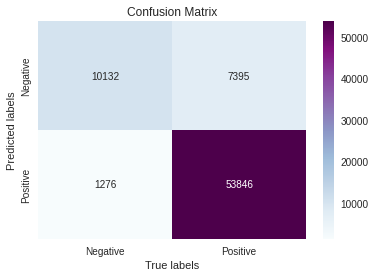

In [ ]:
# apply same tfidf trasformation to test set
X_test_tfidf = vect_tfidf.transform(X_test.astype(str))
# apply same dimensionality reduction to test set
X_test_tfidf = svd_tfidf.transform(X_test_tfidf)

# evaluate prediction on TEST set
y_pred_logreg_tfidf = evaluate_prediction(logreg_tfidf, X_test_tfidf, y_test)

<p align='justify'>
We can see how the representation with tf-idf obtains about the same results but manages to <i>slightly improve the recall of the 'negative' class. </i> Also the global accuracy as improved. <br>
If we check the most informative features we can see that are very similare to the previous model, and they are still not so easily interpretable.
</p>

In [ ]:
show_most_informative_features(vect_bow, logreg_tfidf)

	-9.5006	abysm          		37.2341	aback          
	-7.0345	act            		9.9528	abl            
	-6.0542	abroad         		8.8617	acai           
	-5.6912	accomod        		7.8147	absorpt        
	-5.4577	address        		7.7311	acquir         
	-5.2572	ace            		6.8134	advis          
	-4.6249	aberr          		6.5639	advantag       
	-4.5167	anim           		6.2660	acv            
	-4.3822	acclim         		6.1684	anoth          
	-4.2512	appli          		6.1349	across         
	-4.2080	accur          		5.8619	abdomin        
	-4.1688	abomin         		5.8139	afternoon      
	-4.1466	analog         		5.6212	acceler        
	-4.0119	absorb         		5.2323	acacia         
	-4.0075	abund          		5.1508	accept         
	-3.9232	afteral        		4.8952	aafco          
	-3.8584	altura         		4.7131	acidi          
	-3.7879	accuraci       		4.5681	accentu        
	-3.7368	amo            		4.4606	ac             
	-3.7361	addendum       		4.3238	actor          


## SVM
<p align='justify'>
We now try a different classifier using the SVM method. The classic SVM classifier cannot be applied due to the complexity of the data, so we opted for an <i>approximate version that allows very fast execution times</i>. However, the results obtained are not as good as can be seen in the next analyzes. 
</p>


### BOW
Using BOW reppresentations with SVM classifier

In [ ]:
%%time

# approximating rbf kernel
rbf_feature_bow = RBFSampler(gamma=1, random_state=1)
# transform bow features by using the kernel
X_features = rbf_feature_bow.fit_transform(X_train_bow)
# applying the classifier
svm_bow = SGDClassifier(max_iter=25)
svm_bow = svm_bow.fit(X_features, y_train)

CPU times: user 2.99 s, sys: 114 ms, total: 3.1 s
Wall time: 2.57 s


              precision    recall  f1-score   support

    Negative       0.45      0.52      0.48     39926
    Positive       0.58      0.51      0.54     51340

    accuracy                           0.52     91266
   macro avg       0.52      0.52      0.51     91266
weighted avg       0.52      0.52      0.52     91266



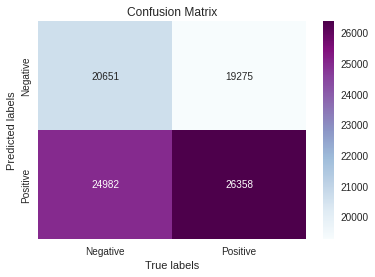

In [ ]:
# score on training
_ = evaluate_prediction(svm_bow, X_features, y_train)

              precision    recall  f1-score   support

    Negative       0.43      0.16      0.23     31587
    Positive       0.57      0.84      0.68     41062

    accuracy                           0.54     72649
   macro avg       0.50      0.50      0.45     72649
weighted avg       0.51      0.54      0.48     72649



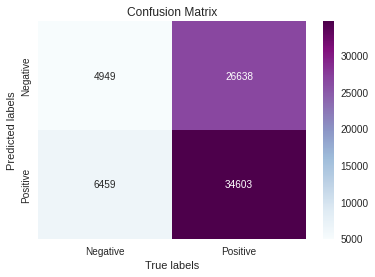

In [ ]:
# evaluate prediction on test set
y_pred_svm_bow = evaluate_prediction(svm_bow, rbf_feature_bow.transform(X_test_bow), y_test)

<p align='justify'>
In this case we can see how the classifier is <i>overfitting only the 'negative' class </i> during training, furthermore there is a <i>significant worsening </i> compared to the use of logistic regression! <br>
Now we can focus to the most informative features that are still strange and not easily interpretable.
</p>

In [ ]:
show_most_informative_features(vect_bow, svm_bow)

	-0.9977	acknowledg     		1.3600	addict         
	-0.8549	actor          		1.1531	abomin         
	-0.6857	accommod       		0.8156	abil           
	-0.6681	ach            		0.7884	action         
	-0.6669	access         		0.6602	accord         
	-0.6596	abit           		0.6472	acr            
	-0.6045	abysm          		0.5666	abc            
	-0.5702	abhor          		0.5478	abroad         
	-0.5391	abbey          		0.5272	abras          
	-0.4870	acceler        		0.5259	absenc         
	-0.4576	accordingli    		0.5234	accident       
	-0.4557	actulli        		0.5216	absinth        
	-0.4463	abid           		0.5153	academi        
	-0.4349	acquaint       		0.5049	accessori      
	-0.4280	aacut          		0.4874	accompani      
	-0.3879	acai           		0.4628	acut           
	-0.3860	accentu        		0.3814	accus          
	-0.3774	across         		0.3454	acquisit       
	-0.3759	acidophilu     		0.3325	adam           
	-0.3567	acn            		0.3168	adag           


### TF-IDF
<p align='justify'>
We try to use the tf-idf representation that before with the logistic classifier works better that the bow representation.
</p>

In [ ]:
%%time

# approximating rbf kernel
rbf_feature_tfidf = RBFSampler(gamma=1, random_state=1)
# transform bow features by using the kernel
X_features = rbf_feature_tfidf.fit_transform(X_train_tfidf)
# applying the classifier
svm_tfidf = SGDClassifier(max_iter=25)
svm_tfidf = svm_tfidf.fit(X_features, y_train)

CPU times: user 3.61 s, sys: 169 ms, total: 3.77 s
Wall time: 2.65 s


              precision    recall  f1-score   support

    Negative       0.60      0.64      0.62     42403
    Positive       0.67      0.62      0.65     48863

    accuracy                           0.63     91266
   macro avg       0.63      0.63      0.63     91266
weighted avg       0.64      0.63      0.63     91266



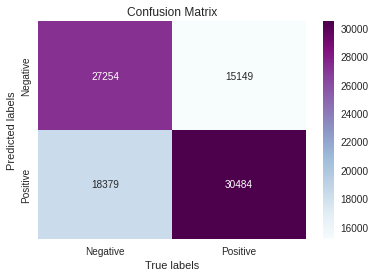

In [ ]:
# score on training set
_ = evaluate_prediction(svm_tfidf, X_features, y_train)

              precision    recall  f1-score   support

    Negative       0.59      0.25      0.35     27182
    Positive       0.67      0.90      0.76     45467

    accuracy                           0.65     72649
   macro avg       0.63      0.57      0.56     72649
weighted avg       0.64      0.65      0.61     72649



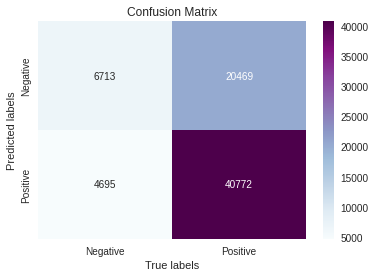

In [ ]:
# evaluate on TEST set
y_pred_svm_tfidf = evaluate_prediction(svm_tfidf, 
                                       rbf_feature_tfidf.transform(X_test_tfidf), 
                                       y_test)

<p align='justify'>
As in the previous case, we see that the tf-idf representation performs better. Again, however, there is an overfitting on the 'negative' class. If we check the overall score the logistic classifier remains better also in this case.
</p>

In [ ]:
show_most_informative_features(vect_tfidf, svm_tfidf)

	-3.8659	acerola        		1.9398	absent         
	-1.8289	account        		1.7075	aback          
	-1.7665	accord         		1.6704	accus          
	-1.7058	adag           		1.5869	accommod       
	-1.6207	accentu        		1.4003	accompani      
	-1.5949	adam           		1.3878	ace            
	-1.5379	add            		1.2462	abil           
	-1.5065	addict         		1.2128	absinth        
	-1.4484	accessori      		1.0423	addendum       
	-1.2656	accid          		0.8704	actulli        
	-1.2095	abdomin        		0.8077	action         
	-1.2010	aacut          		0.7917	absolutli      
	-1.1568	accordingli    		0.7476	absorpt        
	-1.1389	acacia         		0.7356	abroad         
	-1.0325	aa             		0.7243	acidophilu     
	-0.9760	absolut        		0.7031	abv            
	-0.9454	acquir         		0.5903	adagio         
	-0.7632	accumul        		0.5887	acut           
	-0.7334	abras          		0.5539	abc            
	-0.7031	acceler        		0.5188	acm            


Also the most informative features seems to be not so usefull, again easy words such as good, bad are missing.

## Light
<p align='justify'>
LightGBM will be the last classifier we try. This is a very fast, distributed, high performance gradient boosting framework based on decision tree algorithms.
</p>


### BOW

In [ ]:
%%time
# build the lightgbm model
lgb_bow = lgb.LGBMClassifier()
lgb_bow = lgb_bow.fit(X_train_bow, y_train)

CPU times: user 1min 59s, sys: 1.56 s, total: 2min 1s
Wall time: 1min 9s


              precision    recall  f1-score   support

    Negative       0.85      0.84      0.84     46281
    Positive       0.83      0.85      0.84     44985

    accuracy                           0.84     91266
   macro avg       0.84      0.84      0.84     91266
weighted avg       0.84      0.84      0.84     91266



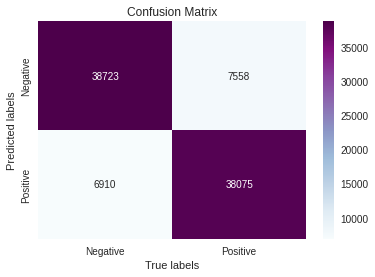

In [ ]:
# score on training
_ = evaluate_prediction(lgb_bow, X_train_bow, y_train)

              precision    recall  f1-score   support

    Negative       0.82      0.43      0.57     21483
    Positive       0.80      0.96      0.87     51166

    accuracy                           0.80     72649
   macro avg       0.81      0.70      0.72     72649
weighted avg       0.81      0.80      0.78     72649



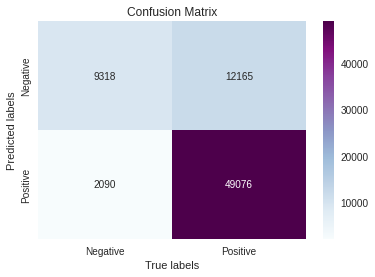

In [ ]:
# evaluation metrics on TEST set
y_pred_lgb_bow = evaluate_prediction(lgb_bow, X_test_bow, y_test)

<p align='justify'>
As already observed with the previous classifiers, the bows representation is not very efficient for the 'negative' class. While in this case there is no overfitting for the 'positive' class.
</p>

### TF-IDF

In [ ]:
%%time
# building classifier on tf-idf
lgb_tfidf = lgb.LGBMClassifier()
lgb_tfidf = lgb_tfidf.fit(X_train_tfidf, y_train)

CPU times: user 5min 12s, sys: 11.9 s, total: 5min 24s
Wall time: 3min 36s


              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86     46637
    Positive       0.85      0.87      0.86     44629

    accuracy                           0.86     91266
   macro avg       0.86      0.86      0.86     91266
weighted avg       0.86      0.86      0.86     91266



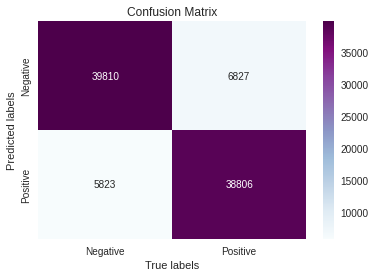

In [ ]:
# score training set
_ = evaluate_prediction(lgb_tfidf, X_train_tfidf, y_train)

              precision    recall  f1-score   support

    Negative       0.84      0.47      0.61     20286
    Positive       0.83      0.97      0.89     52363

    accuracy                           0.83     72649
   macro avg       0.83      0.72      0.75     72649
weighted avg       0.83      0.83      0.81     72649



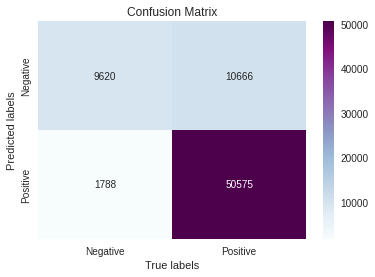

In [ ]:
# evaluation on TEST set
y_pred_lgb_tfidf = evaluate_prediction(lgb_tfidf, X_test_tfidf, y_test)

<p align='justify'>
Also for the representation TF-IDF the behavior is very similar to what was observed in the preceding, i.e. it performs slightly better than bow but there are still problems with the recall of the 'negative' class.
</p>

In [ ]:
# Printing first 20 rows of test set, with their predicted y by using a dataframe
df = pd.DataFrame()

df['y'] = y_test # real y
df['pred1'] = y_pred_logreg_tfidf # predicted y with logistic regression
df['pred2'] = y_pred_svm_tfidf # predicted y with SVM
df['pred3'] = y_pred_lgb_tfidf # predicted y with light lgbm
df['X'] = X_test # test set

i = 0

# print 20 random rows
for _, row in shuffle(df).iterrows():
  if row['y'] != row['pred1']:
    print(row['X'])
    print(row['y'], row['pred1'], row['pred2'], row['pred3'])
    i = i +1

  if i == 20:
    break

['twine', 'recogn', 'leader', 'tea', 'product', 'regular', 'decaffein', 'english', 'breakfast', 'tea', 'not', 'disappoint', 'full', 'flavor', 'lack', 'bitter', 'not', 'jazz', 'like', 'caffein', 'version', 'cost', 'competit', 'free', 'ship', 'also', 'bonu']
1 0 1 0
['coffe', 'chocol', 'go', 'togeth', 'well', 'not', 'think', 'part', 'prefer', 'way', 'blend', 'tast', 'smell', 'make', 'nice', 'combin']
1 0 0 0
['good', 'idea', 'natur', 'meat', 'filler', 'cat', 'terribl', 'digest', 'issu', 'food', 'introduc', 'littl', 'time', 'miser', 'diahrrea', 'day', 'clean', 'poop', 'throw', 'back', 'scienc', 'diet', 'friski', 'feb', 'tri', 'new', 'kitti', 'month', 'old', 'bubba', 'ad', 'tablespoon', 'time', 'commerci', 'food', 'day', 'period', 'spend', 'everi', 'day', 'clean', 'diahrea', 'state', 'rich', 'kitti', 'back', 'scienc', 'diet', 'everybodi']
0 1 1 1
['shock', 'recent', 'see', 'cost', 'solo', 'almond', 'past', 'realli', 'excit', 'see', 'price', 'could', 'get', 'cooki']
1 0 0 0
['golden', 'moun

<p align='justify'>
From the previous report we can see that most of misclassified reviews contains the word 'not'. For this reason we try to <i>overcome this problem by using n-grams representation</i>, since the TF-IDF representation seems to work better in all cases we decided to try with n-grams based on TF-IDF.
</p>

## N-grams
<p align='justify'>
We use the same method used previously for the basic tf-idf representation, but this time through the appropriate parameter we consider both single words (as before) and pairs of words (n-grams with $n = 2$). Furthermore as classifier we decided to use the logistic regression because it achieve the best results with the basic representation methods that we have used since now. <br>
Since this representation uses a lot of space and there are many variables that we no longer use, we free up the memory to avoid problems during execution. 
</p>

In [ ]:
# removing some variables in order to save memory for ngrams algorithms
del X_test_tfidf, X_train_tfidf, X_test_bow, X_train_bow, 
del lgb_tfidf, df_copy, logreg_bow, logreg_tfidf, negative, positive, svd_bow, 
del svd_tfidf, svm_tfidf, rbf_feature_tfidf, rbf_feature_bow, data
del vect_bow, vect_tfidf, stopwords, df_temp, svm_bow, X_features, lgb_bow
del y_pred_logreg_bow,y_pred_logreg_tfidf, y_pred_svm_bow, y_pred_svm_tfidf,
del y_pred_lgb_bow, y_pred_lgb_tfidf

In [ ]:
# saving fitted tf-idf
ngrams_tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train.astype(str))

# apply it on training set
X_train_ngrams_tfidf = ngrams_tfidf.transform(X_train.astype(str))

# check results
X_train_ngrams_tfidf

<91266x123722 sparse matrix of type '<class 'numpy.float64'>'
	with 4916031 stored elements in Compressed Sparse Row format>

In [ ]:
# fitting truncated SVD on training set
svd_ngrams = TruncatedSVD(n_components=1500).fit(X_train_ngrams_tfidf)

print('TF-IDF bigrams explained variance:', svd_ngrams.explained_variance_ratio_.sum())

# applying SVD to X_train
X_train_ngrams_tfidf = svd_ngrams.transform(X_train_ngrams_tfidf)

TF-IDF bigrams explained variance: 0.33667724871487126


<p align='justify'>
We can see that the explained variance is much lower than before even if we use the same number of remaining features, $1500$. Furthermore we can see that now we have a matrix with the same number of documents but with $123943$ instead of $12171$, due to the fact that we are now representing also bi-grams.
</p>

In [ ]:
%%time

# instantiate logistic regression method
logreg_ngrams_tfidf = LogisticRegression(max_iter=200)
# fitting model on training data for bow
logreg_ngrams_tfidf = logreg_ngrams_tfidf.fit(X_train_ngrams_tfidf, y_train)

print('<------------- TF-IDF bigrams parameters ------------->')
print('Logistic regression intercept for bow:', logreg_ngrams_tfidf.intercept_)
# only print first 10 coefficients
print('Logistic regression first 10 coefficients for bow:', logreg_ngrams_tfidf.coef_[0][0:10], '\n\n')

<------------- TF-IDF bigrams parameters ------------->
Logistic regression intercept for bow: [-0.27765182]
Logistic regression first 10 coefficients for bow: [ 1.05906774  2.84205316 -2.36790715  5.73285734  1.51060295 50.01129976
  0.31783378 -2.52567105 10.72592609 -7.5220776 ] 


CPU times: user 18.7 s, sys: 1.03 s, total: 19.7 s
Wall time: 10.5 s


              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93     45803
    Positive       0.93      0.94      0.93     45463

    accuracy                           0.93     91266
   macro avg       0.93      0.93      0.93     91266
weighted avg       0.93      0.93      0.93     91266



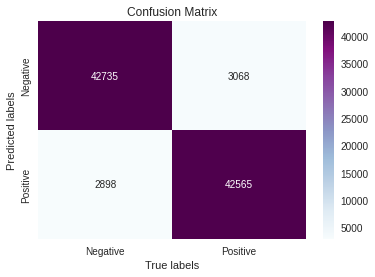

In [ ]:
# score the training set
_ = evaluate_prediction(logreg_ngrams_tfidf, X_train_ngrams_tfidf, y_train)

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73     16766
    Positive       0.89      0.98      0.93     55883

    accuracy                           0.89     72649
   macro avg       0.89      0.79      0.83     72649
weighted avg       0.89      0.89      0.89     72649



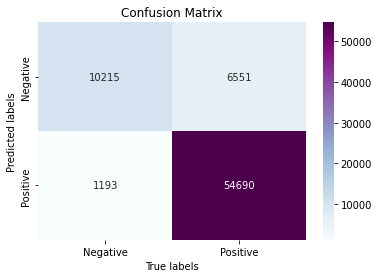

In [ ]:
# apply same bow trasformation to test set
X_test_ngrams_tfidf = ngrams_tfidf.transform(X_test.astype(str))
# apply same dimensionality reduction to test set
X_test_ngrams_tfidf = svd_ngrams.transform(X_test_ngrams_tfidf)

# get score prediction on test set
y_pred_ngrams_tfidf = evaluate_prediction(logreg_ngrams_tfidf, 
                                          X_test_ngrams_tfidf, y_test)

In [ ]:
show_most_informative_features(ngrams_tfidf, logreg_ngrams_tfidf)

	-13.8783	disappoint     		13.5828	great          
	-10.3715	not            		11.4268	delici         
	-9.7754	not recommend  		11.3074	best           
	-8.8912	worst          		10.6514	love           
	-8.6430	not good       		9.8481	perfect        
	-8.5169	not buy        		9.2003	good           
	-8.0209	not worth      		8.8540	not disappoint 
	-7.6340	terribl        		8.1196	excel          
	-7.4375	unfortun       		7.2719	favorit        
	-7.3566	aw             		7.1035	nice           
	-6.7330	horribl        		6.9527	amaz           
	-6.5910	return         		6.6659	happi          
	-6.5361	thought        		6.4162	tasti          
	-6.2196	stale          		6.3190	awesom         
	-6.0218	bland          		6.1788	highli recommend
	-5.9788	threw          		6.0054	wonder         
	-5.8013	bad            		5.7210	easi           
	-5.6184	not order      		5.7190	smooth         
	-5.5137	refund         		5.7069	addict         
	-5.4828	weak           		5.6696	yummi          


<p align='justify'>
This $2$-grams representation achieve the best results either on 'positive' and 'negative' class, but as before we can see that the 'negative' class is overfitted during the training. With this new representation we were therefore able to improve the overall result and gain some further points on the recall of the 'negative' class, which is still not optimal. Furthermore we can now see that the most informative features are interpretable and seems to be better than before.
</p>


In [ ]:
# I try to visualize some test rows as before to understand what happens
df['pred4'] = y_pred_ngrams_tfidf

i = 0

# print 10 random rows with text + real y value + n_grams predicted value
for _, row in shuffle(df).iterrows():
  if row['y'] != row['pred4']:
    print(row['X'])
    print(row['y'], row['pred4'])
    i = i +1

  if i == 10:
    break

['first', 'let', 'say', 'kind', 'coffe', 'drinker', 'get', 'keurig', 'drank', 'mostli', 'folder', 'medium', 'blend', 'not', 'anyth', 'ga', 'station', 'coffe', 'fact', 'drink', 'lot', 'like', 'cappuccino', 'get', 'casey', 'not', 'like', 'vend', 'machin', 'coffe', 'chalki', 'gritti', 'thought', 'coffe', 'remind', 'lot', 'get', 'casey', 'pretti', 'sweet', 'stuff', 'casey', 'ga', 'station', 'usual', 'get', 'cappuccino', 'coffe', 'not', 'necessari', 'water', 'coffe', 'right']
1 0
['like', 'poop', 'bag', 'pretti', 'durabl', 'claim', 'biodegrad', 'buy']
1 0
['back', 'sail', 'india', 'first', 'trip', 'sea', 'deck', 'cadet', 'anchor', 'sequenti', 'sever', 'town', 'along', 'malabar', 'coast', 'load', 'ton', 'burlap', 'bag', 'fill', 'local', 'produc', 'peppercorn', 'wooden', 'sail', 'barg', 'came', 'coastal', 'town', 'tie', 'alongsid', 'ship', 'first', 'port', 'call', 'chief', 'mate', 'gave', 'bunch', 'empti', 'coffe', 'can', 'told', 'go', 'onto', 'barg', 'make', 'notat', 'broken', 'rip', 'bag', 

<p align='justify'>
It seems that now the word 'not' is correctly used by the classifier. However some problems remain, for example some simple reviews remain incorrectly classified while other problems are probably due to the complexity of the words used such as: <br>
<center> ['not', 'kid', 'not', 'tast', 'like', 'pasta', 'howev', 'go', 'extrem', 'well', 'veget', 'stir', 'fri', 'throw', 'right' ....] </center>

That is classified as negative probably for the first words but the real label of this review is positive because after the words 'however' the review changes

In [ ]:
# removing all remaining classification variables for saving memory
del X_test_ngrams_tfidf, X_train_ngrams_tfidf, ngrams_tfidf, svd_ngrams, df
del logreg_ngrams_tfidf, y_pred_ngrams_tfidf

## Neural network
<p align='justify'>
Since the standard approaches as seen have not been able to completely overcome the recall problem for the 'negative' class, it was decided to try a <i>deep learning approach</i>. Specifically, this approach is supervised learning that uses an embedding layer. We will use this particular set of parameters:

* Vocabulry size is 10000
* One Embedding layer translate the each index into a vector of size 100
* Input size is 100 words (100 word per review), reviews with more than 100 words will be cutted at that points while reviews with less than 100 words will be filled automatically.

We choose not to use Word2Vec or other pretrained model because we want to try to learn the embedding by using the model. But this could be a possible improvement!

</p>

In [ ]:
voc_size = 10000 # vocabulary size
max_len = 100 # input size
embedding_dim = 100 # embedding size

In order to embedd our textual data we need to transform it into integer vectors.

In [ ]:
# create the tokenizer
tokenizer = Tokenizer(num_words = voc_size)
# fit the tokenizer on training data
tokenizer.fit_on_texts(X_train)

# apply tokenizer to training and test data (from string to integer vectors)
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

# paddding each reviews to 100 words (cut to 100 if more words are present)
X_train_tok = pad_sequences(X_train_tok, maxlen = max_len)
X_test_tok = pad_sequences(X_test_tok, maxlen = max_len)

In [ ]:
# building the model
model=Sequential()
# embedding layer, map eah word index to a dense vector of size 100
model.add(Embedding(voc_size, embedding_dim, input_length=max_len)) 
# First GRU layer, output size is 1 vector of size 32
model.add(GRU(32,dropout=0.5))
# last layer is dense that move 32 size array to 1 with a dense layer and apply sigmoid
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,012,897
Trainable params: 1,012,897
Non-trainable params: 0
_________________________________________________________________


<p align='justify'>
The model above is one of the possible valid models, it was selected by observing both the performance and the execution time required by other models with multiple layers or with a single LSTM layer instead of GRU. Once selected and build we can train the model. <br>
Since the training can vary in the single iterations it is difficult to select the correct number of epochs for each case series. For this reason, the early stopping regularization technique has been introduced, which allows the model to be stopped if $2$ consecutive epochs get worse. Specifically, it was decided to restore the best weights found up to the moment of the stop and to check the accuracy on the validation set as a metric for the stop. 
</p>

In [ ]:
%%time
# binary cross entropy and Adam optimizer with learning rate 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',metrics=['accuracy'])


# add early stopping, stop the model if for 2 epochs the performance get worse 
# and restore the best weights
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, 
                                               patience=2, min_delta = 0.001, 
                                               mode='min', 
                                               restore_best_weights=True)

# keep 20% of data as validation
history = model.fit(X_train_tok, y_train, epochs=10, batch_size=128, 
                    validation_split=0.2, callbacks = [early_stopping])

print('\n\n')

Epoch 1/10
571/571 [==============================] - 20s 26ms/step - loss: 0.3599 - accuracy: 0.8410 - val_loss: 0.2841 - val_accuracy: 0.8872
Epoch 2/10
571/571 [==============================] - 14s 24ms/step - loss: 0.2636 - accuracy: 0.8944 - val_loss: 0.2669 - val_accuracy: 0.8945
Epoch 3/10
571/571 [==============================] - 14s 24ms/step - loss: 0.2289 - accuracy: 0.9104 - val_loss: 0.2650 - val_accuracy: 0.8943
Epoch 4/10
571/571 [==============================] - 14s 24ms/step - loss: 0.2042 - accuracy: 0.9212 - val_loss: 0.2675 - val_accuracy: 0.8931
Epoch 5/10
571/571 [==============================] - 14s 25ms/step - loss: 0.1870 - accuracy: 0.9285 - val_loss: 0.2814 - val_accuracy: 0.8928
Epoch 00005: early stopping



CPU times: user 1min 2s, sys: 4.91 s, total: 1min 7s
Wall time: 1min 15s


We can see that the early stopping works as expected and restore the weights trained at epoch 3.

In [ ]:
# print some basic info
print("Total number of epochs:", len(history.epoch))
print("Best epoch (weights restored):", (early_stopping.best_epoch+1))
print("Accuracy training set at epoch", (early_stopping.best_epoch+1), ":", 
      history.history['accuracy'][early_stopping.best_epoch])
print("Accuracy validation set at epoch", (early_stopping.best_epoch+1), ":", 
      history.history['val_accuracy'][early_stopping.best_epoch])
print("Loss training set at epoch", (early_stopping.best_epoch+1), ":", 
      history.history['loss'][early_stopping.best_epoch])
print("Loss validation set at epoch", (early_stopping.best_epoch+1), ":", 
      history.history['val_loss'][early_stopping.best_epoch])

Total number of epochs: 5
Best epoch (weights restored): 3
Accuracy training set at epoch 3 : 0.9104393720626831
Accuracy validation set at epoch 3 : 0.894324541091919
Loss training set at epoch 3 : 0.22886228561401367
Loss validation set at epoch 3 : 0.26504820585250854


<p align='justify'>
We can check the training history by plotting the accuracy and the loss for training and validation set.
</p>

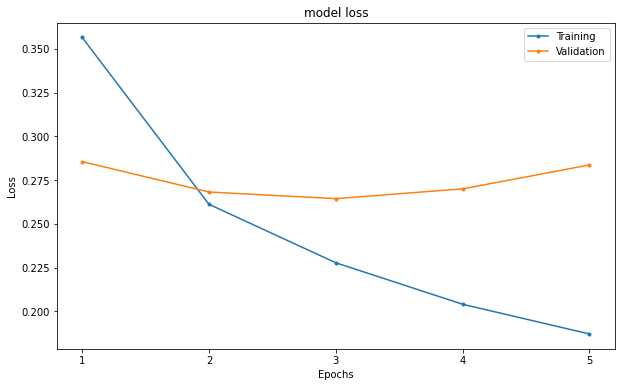

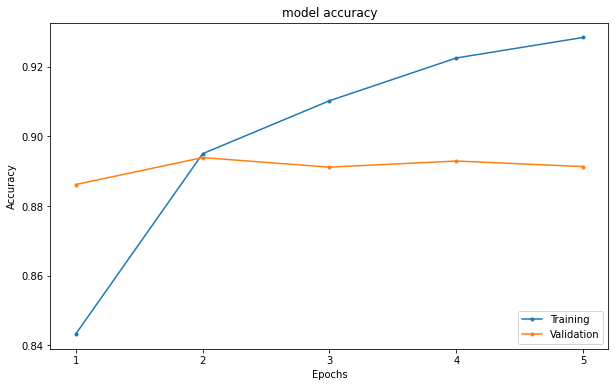

In [ ]:
# function to visualize the training model history
def plot_history(network_history):
    plt.figure(figsize = (10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # rearange the x-axis values
    plt.xticks(np.arange(len(network_history.epoch)), np.arange(1, len(network_history.epoch)+1))
    plt.title('model loss')
    plt.plot(network_history.history['loss'], marker='.')
    plt.plot(network_history.history['val_loss'], marker='.')
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize = (10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(len(network_history.epoch)), np.arange(1, len(network_history.epoch)+1))
    plt.title('model accuracy')
    plt.plot(network_history.history['accuracy'], marker='.')
    plt.plot(network_history.history['val_accuracy'], marker='.')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()



plot_history(history)

<p align='justify'>
From the plot we can see that the model is overfitting the training data starting from the epoch $3$. Furthermore we must remember that the values of the epochs after the $ 3 $ are plotted but in reality they have been discarded thanks to early stopping. 
</p>

              precision    recall  f1-score   support

    Negative       0.90      0.58      0.71     17753
    Positive       0.88      0.98      0.93     54896

    accuracy                           0.88     72649
   macro avg       0.89      0.78      0.82     72649
weighted avg       0.88      0.88      0.87     72649



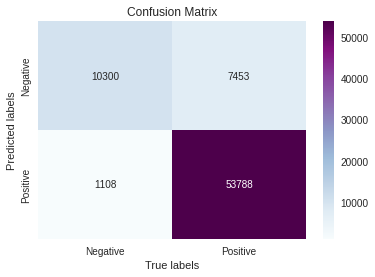

In [ ]:
# evaluation on TEST set
_ = evaluate_prediction(model, X_test_tok, y_test)

From the final results it can be seen that even with this neural model the scores are almost identical to those obtained with n-grams. This leads us to think that correctly classifying all the possible texts is not easy, a possible improvement as already mentioned could be to consider a pretrained model (Word2Vec or Glove) for embedding. <br>


In [ ]:
# saving the model for future use
# model.save(drive_path + 'Keras_Model/binary_classification_model.h5')

# Classification task 2 *
The previous task considers only the positive (score = $4$ or $5$) and negative (score = $1$ or $2$) votes. Let's try using a neural network to carry out a <b> multi class classification</b>, in this case an embedding layer will be applied starting from the preprocessed text and through an LSTM network we will try to predict the real score in the $[1,5]$ range.
As before we will not use pretrained Word2Vec of Glove models, and we use the same parameters for the embedding layers. <br>
Since now we have used binary data for y_score so we need to extract new training and test set from the original dataset but this time we keep all information about scores.


In [ ]:
# extracting training and test set
X_train, X_test, y_train, y_test = train_test_split(df_reviews['Stem_Text'], 
                                                    df_reviews['Score'], 
                                                    test_size=0.20,
                                                    random_state=56, 
                                                    stratify=df_reviews['Score'])

As before we need to balanced classes.

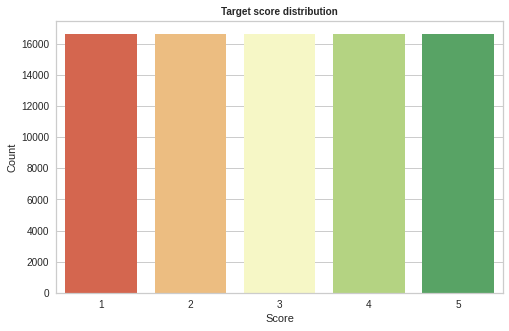

In [ ]:
# append the target column to x_train dataset, to simplify resizing 
# they will split again later
df_temp = pd.concat([X_train, y_train], axis = 1)

# extract sample for each class
class_2 = df_temp.loc[df_temp['Score'] == 2] # ~16000
class_1 = df_temp.loc[df_temp['Score'] == 1].sample(class_2.shape[0])
class_3 = df_temp.loc[df_temp['Score'] == 3].sample(class_2.shape[0])
class_4 = df_temp.loc[df_temp['Score'] == 4].sample(class_2.shape[0])
class_5 = df_temp.loc[df_temp['Score'] == 5].sample(class_2.shape[0]) 


data = pd.concat([class_1, class_2, class_3, class_4, class_5])
# shuffling data
data = shuffle(data, random_state = 43)

# splitting X and y from the dataset
X_train = data['Stem_Text']
y_train = data['Score']

# Checking if also y_train is balanced now
plt.figure(figsize=(8,5))
sns.countplot(x = y_train, palette=sns.color_palette("RdYlGn", 5))

plt.title("Target score distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Count")
plt.show();

After balancing the class we can start to create the model. As before we first convert our data into integer vectors

In [ ]:
# create the tokenizer
tokenizer = Tokenizer(num_words = voc_size)
# fit the tokenizer on training data
tokenizer.fit_on_texts(X_train)

# apply tokenizer to training and test data (from string to integer vectors)
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

# paddding each reviews to 100 words (cut to 100 if more words are present)
X_train_tok = pad_sequences(X_train_tok, maxlen = max_len)
X_test_tok = pad_sequences(X_test_tok, maxlen = max_len)

<p align='justify'>
In this case we need to apply a further step, y_train is in range $[1,5]$ but keras is expecting the first label to be $0$. So we change the range to $[0,4]$ and we convert all labels to categorical array.
</p>

In [ ]:
# y_train to [0,4] range and to categorical
yc_train = to_categorical(y_train-1)

In [ ]:
# building the model
model2=Sequential()
# embedding layer, map eah word index to a dense vector of size 100
model2.add(Embedding(voc_size, embedding_dim, input_length=max_len)) 
# First LSTM layer, input and output size same (100), each vetor is 32
model2.add(LSTM(32,dropout=0.1,return_sequences=True))
# Second LSTM layer vector of 64
model2.add(LSTM(64,dropout=0.1))
# last layer is dense that move 32 size array to 5 with a dense layer and apply softmax
model2.add(Dense(5,activation='softmax'))
model2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 lstm_18 (LSTM)              (None, 100, 32)           17024     
                                                                 
 lstm_19 (LSTM)              (None, 64)                24832     
                                                                 
 dense_18 (Dense)            (None, 5)                 325       
                                                                 
Total params: 1,042,181
Trainable params: 1,042,181
Non-trainable params: 0
_________________________________________________________________


<p align='justify'>
Unlike before this time we use a categorical crossentropy as we have to classify $5$ different classes, we also increase the number of examples per batch to $1024$ as more examples are available. 
</p>

In [ ]:
%%time
# binary cross entropy and Adam optimizer with learning rate 0.001
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',metrics=['accuracy'])

# keep 20% of data as validation. Same early_stopping defined before
history2 = model2.fit(X_train_tok, yc_train, epochs=15, batch_size=1024, shuffle = True,
                      validation_split=0.10, callbacks = [early_stopping])

print('\n\n')

Epoch 1/15
74/74 [==============================] - 18s 131ms/step - loss: 1.4170 - accuracy: 0.3668 - val_loss: 1.2476 - val_accuracy: 0.4549
Epoch 2/15
74/74 [==============================] - 8s 112ms/step - loss: 1.1758 - accuracy: 0.4942 - val_loss: 1.2015 - val_accuracy: 0.4777
Epoch 3/15
74/74 [==============================] - 8s 104ms/step - loss: 1.1178 - accuracy: 0.5221 - val_loss: 1.2011 - val_accuracy: 0.4803
Epoch 4/15
74/74 [==============================] - 8s 101ms/step - loss: 1.0869 - accuracy: 0.5362 - val_loss: 1.1956 - val_accuracy: 0.4885
Epoch 5/15
74/74 [==============================] - 8s 102ms/step - loss: 1.0612 - accuracy: 0.5487 - val_loss: 1.2097 - val_accuracy: 0.4820
Epoch 6/15
74/74 [==============================] - 8s 102ms/step - loss: 1.0403 - accuracy: 0.5576 - val_loss: 1.2135 - val_accuracy: 0.4860
Epoch 00006: early stopping



CPU times: user 35 s, sys: 1.88 s, total: 36.8 s
Wall time: 56.8 s


Model has been stopped at epoch 6 by the early stopping.

In [ ]:
# print some basic info
print("Total number of epochs:", len(history2.epoch))
print("Best epoch (weights restored):", (early_stopping.best_epoch+1))
print("Accuracy training set at epoch", (early_stopping.best_epoch+1), ":", 
      history2.history['accuracy'][early_stopping.best_epoch])
print("Accuracy validation set at epoch", (early_stopping.best_epoch+1), ":", 
      history2.history['val_accuracy'][early_stopping.best_epoch])
print("Loss training set at epoch", (early_stopping.best_epoch+1), ":", 
      history2.history['loss'][early_stopping.best_epoch])
print("Loss validation set at epoch", (early_stopping.best_epoch+1), ":", 
      history2.history['val_loss'][early_stopping.best_epoch])

Total number of epochs: 6
Best epoch (weights restored): 4
Accuracy training set at epoch 4 : 0.5362351536750793
Accuracy validation set at epoch 4 : 0.48845043778419495
Loss training set at epoch 4 : 1.0869251489639282
Loss validation set at epoch 4 : 1.1955583095550537


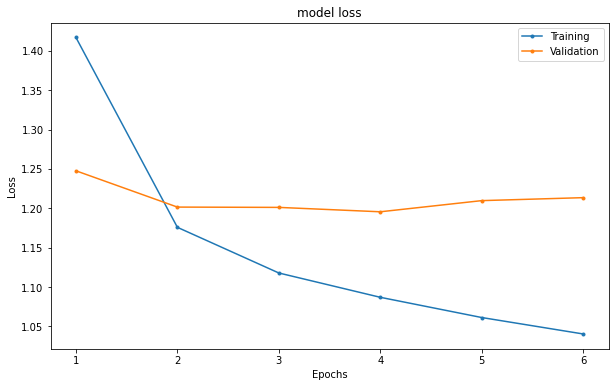

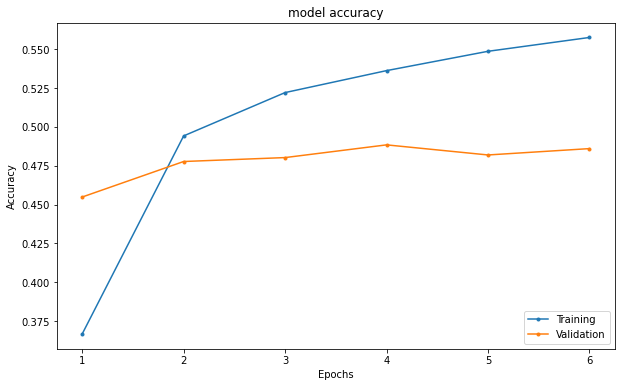

In [ ]:
plot_history(history2) # visualize training

<p align='justify'>
The graph shows the presence of an <i>accentuated overfitting</i>, always remembering that the last two epochs are not actually effective as the weights of the $ 4 $ epoch are restored from the early stopping. 
</p>

              precision    recall  f1-score   support

           1       0.18      0.94      0.30      7252
           2       0.36      0.06      0.10      4156
           3       0.39      0.11      0.17      5945
           4       0.33      0.23      0.27     11191
           5       0.91      0.55      0.68     50050

    accuracy                           0.48     78594
   macro avg       0.43      0.38      0.30     78594
weighted avg       0.69      0.48      0.52     78594
 




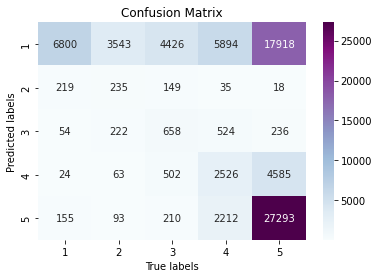

In [ ]:
# Evaluation on TEST set
y_pred = np.argmax(np.round(model2.predict(X_test_tok)),1)
targets = ['1', '2', '3', '4', '5']

print(classification_report(y_test-1, y_pred, target_names=targets), '\n\n')

cm = confusion_matrix(y_pred, y_test-1)

# plot beautiful confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu");  

ax.set_xticklabels(targets)
ax.set_yticklabels(targets)
ax.set_xlabel('True labels'); 
ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 

<p align='justify'>
From the above confusion matrix we can see how the classification of the $4$ and $5$ scores is often confused. While for the neutral class ($3$) the greatest number of instances are correctly classified even if here too there are errors and very often it is classified with a score equal to $4$. Finally, it is noted that the $1$ class is the one with the most errors, and above all the score is often confused with diametrically opposite values equal to $4$ or $5$, thus classifying the review as positive rather than negative. <br>

From all these considerations we can conclude that classifying a score in the range $[1,5]$ starting from the text is not a simple task, and even considering more modern approaches with neural networks, the <i>performance does not seem to give the desired results</i>. As with the previous said, you could try using a pretrained model for embedding to try to improve the results. 
</p>

In [ ]:
# saving the model for future use
# model2.save(drive_path + 'Keras_Model/multi_classification_model.h5')

# Clustering task *
<p aling='justify'>
The second NLP task we want to perform is clustering, as before we try different types of clustering based on the TF-IDF representation. Specifically we try to carry out clustering to try to:

1. classify the scores in 5 different clusters
2. divide the different 'topics' from each other. 
</p>

In [ ]:
# removing old data from memory
del model, model2, history, history2, X_train_tok, X_test_tok, yc_train, y_pred
del tokenizer, df_temp, data, class_1, class_2, class_3, class_4, class_5

In [ ]:
%%time
# saving fitted tf-idf
vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_train.astype(str))
# apply it on training set
X_train_tfidf = vect_tfidf.transform(X_train.astype(str))

CPU times: user 7.96 s, sys: 44.8 ms, total: 8 s
Wall time: 8.14 s


In [ ]:
# fitting truncated SVD on training set
svd_tfidf = TruncatedSVD(n_components=1500).fit(X_train_tfidf)

print('Tf-idf explained variance:', svd_tfidf.explained_variance_ratio_.sum())

# applying SVD to X_train
X_train_tfidf = svd_tfidf.transform(X_train_tfidf)

Tf-idf explained variance: 0.7406519022418592


<p align='justify'>
Since we do not want the range of values obtained by tf-idf to negatively affect the identification of clustering, we first apply a standardization. This is not strictly required but can be very useful especially with classic distances such as the Euclidean one, but If one of our features has a range of values much larger than the others, clustering will be completely dominated by that one feature. 
</p>

In [ ]:
# normalizing data
standardized_data_train = preprocessing.normalize(X_train_tfidf)

In [ ]:
# function to compare clusters wordcloud
def display_cluster_wordcloud(data, n_cluster, ncols = 4):
  # get number of rows
  nrows = math.ceil(n_cluster/ncols)

  fig = plt.figure(figsize =(25,30))
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.4, wspace=0.2, hspace=0.2)

  # plot wordcloud for each cluster
  for i in range(0,n_cluster,1):
    plt.subplot(nrows, ncols, 1+i)

    text = " ".join(str(t) for t in np.where(data[1] == i, data[0], ''))
    text = text.replace("'", "")

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white").generate_from_text(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    tit = 'Wordcloud of cluster: ' + str(i)
    plt.title(tit)
    plt.axis("off")


# function to evaluate clustering
def score_clustering(true_labels, predicted_labels, X):
  d = {
      "Rand index": rand_score(true_labels, predicted_labels),
      "Adjusted Mutual Info": adjusted_mutual_info_score(true_labels, predicted_labels),
      "Homogeneity": homogeneity_score(true_labels, predicted_labels),
      "Completeness": completeness_score(true_labels, predicted_labels),
      "V measure": v_measure_score(true_labels, predicted_labels),
      "Fowlkes Mallows": fowlkes_mallows_score(true_labels, predicted_labels),
      "Silhouette": silhouette_score(X, predicted_labels)
  }
  for k, v in d.items():
    print(f"{k:21s}: {v}")

## Clustering visualization
<p align='justify'>
First of all we want to try to visualize the reviews available to us in a $2$D space. We then use T-SNE to reduce the number of features extracted from TF-IDF to $2$ and try to visualize the result to understand what we can expect from clustering. <br>
For computational problems, the reduction will be carried out only on a sub-portion of $500$ reviews, this will generally serve to understand how they are distributed in space even if it will not represent $100\%$ our reality.
</p>

In [ ]:
# reducing data to 2 dimension
svd = TSNE(n_components=2, init='random', learning_rate='auto')
data = svd.fit_transform(X_train_tfidf[0:500]) 

# extracting x and y
scatter_x = data[:, 0]
scatter_y = data[:, 1]

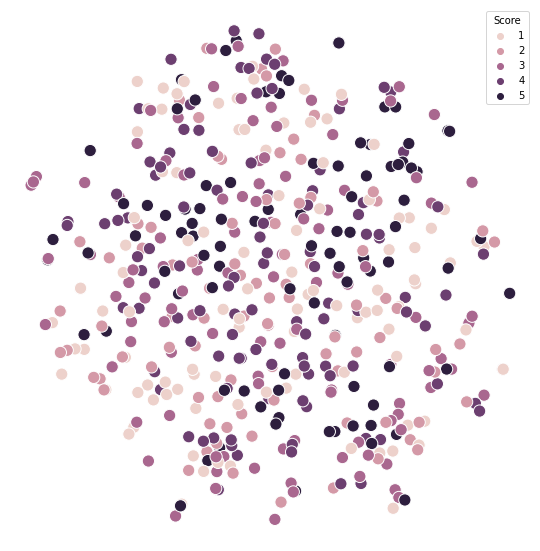

In [ ]:
# Plotting data
plt.figure(figsize=(8, 8))
sns.scatterplot(x = scatter_x, y=scatter_y, hue=y_train[0:500], s=150)
plt.tight_layout()
plt.axis('off')
plt.show()

<p align='justify'>
As you can see, the reviews do not seem to assume a specific positioning with respect to the score, even if we consider the binary case with positive vs negative scores as for the first classification. This first analysis leads to think that the clustering algorithms will not be very efficient if evaluated with respect to the score as ground truth.  <br>
Starting from these considerations, we will first try to analyze and evaluate the clustering with respect to the score, and then we will try to evaluate the semantics and the subdivision of the contents of each cluster by searching for the optimal number of clusters. 
</p>


## K-means on score ground truth
<p align='justify'>
Let's try to classify the texts in 5 different clusters using the classic k-means algorithm. The goal would be to find clusters that contain a specific score. 
</p>


In [ ]:
# setting up kmeans with k = 5. We use standardize features
kmeans = KMeans(n_clusters=5, random_state=83).fit(standardized_data_train)

In [ ]:
# counting element per list
c = Counter(kmeans.labels_)

# print number of element per cluster
for i in range(0,kmeans.n_clusters, 1):
  print('No. of reviews in Cluster-' + str(i) + ': ' + str(c[i]))

No. of reviews in Cluster-0: 4841
No. of reviews in Cluster-1: 6215
No. of reviews in Cluster-2: 40903
No. of reviews in Cluster-3: 23890
No. of reviews in Cluster-4: 7266


In [ ]:
# evaluating clustering performance
score_clustering(y_train, kmeans.labels_, standardized_data_train) # long computation for Silhouette!!!

Rand index           : 0.5981333172465243
Adjusted Mutual Info : 0.008051656398375396
Homogeneity          : 0.007286547678001394
Completeness         : 0.009163022529309783
V measure            : 0.00811775623228642
Fowlkes Mallows      : 0.2670176345603583
Silhouette           : 0.011880372905302599


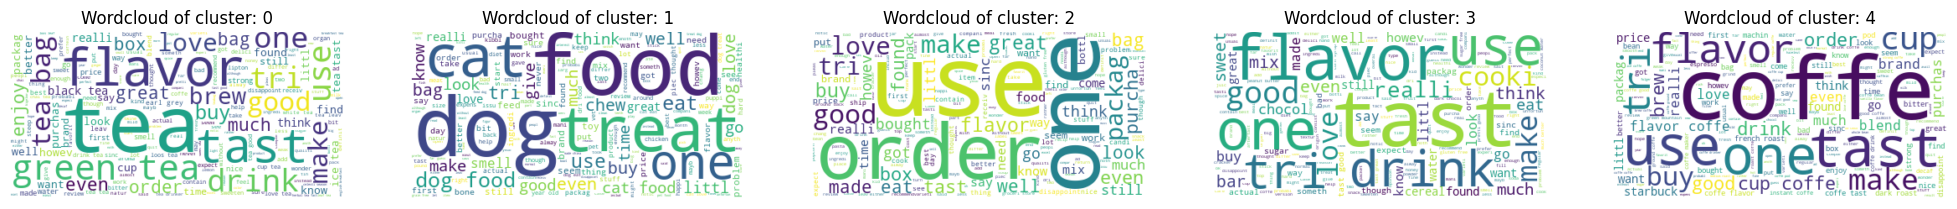

In [ ]:
# visualizing clustering words
display_cluster_wordcloud([X_train, kmeans.labels_], kmeans.n_clusters, ncols = 5)

<p align='justify'>
Looking at the results, we can see that clustering is not very good. Similarly, if we analyze the textual contents of each cluster through the above wordclouds we can see that the terms 'flavor', 'one', 'tast', are repeated in each of them, so clustering does not seem to obtain desired results in this sense as well.
We also tried to use k = 2 to try to cluster the positive and negative reviews but the results were almost the same. 
</p>

## Hierarchical on score ground truth
<p align='justify'>
Now let's try a different hierachic algorithm. Specifically, we use an agglomerative algorithm that step by step tries to join the closest elements until reaching the required number of clusters (k = $5$).
Due to computational and memory problems we will not use all data but only a subset of them.
</p>

In [ ]:
# setting agglomerative clustering with k = 5. We use only 15000 rows
hc = AgglomerativeClustering(n_clusters=5).fit(standardized_data_train[:15000])

In [ ]:
# counting element per list
c = Counter(hc.labels_)

# print number of element per cluster
for i in range(0,hc.n_clusters, 1):
  print('No. of reviews in Cluster-' + str(i) + ': ' + str(c[i]))

No. of reviews in Cluster-0: 11747
No. of reviews in Cluster-1: 641
No. of reviews in Cluster-2: 1534
No. of reviews in Cluster-3: 798
No. of reviews in Cluster-4: 280


In [ ]:
# evaluating clustering performance
score_clustering(y_train[:15000], hc.labels_,standardized_data_train[:15000])

Rand index           : 0.4230088583683357
Adjusted Mutual Info : 0.0011221649188717187
Homogeneity          : 0.0011680343902362516
Completeness         : 0.0023802389639944535
V measure            : 0.0015670725952446239
Fowlkes Mallows      : 0.3549546141524873
Silhouette           : 0.005335375457491175


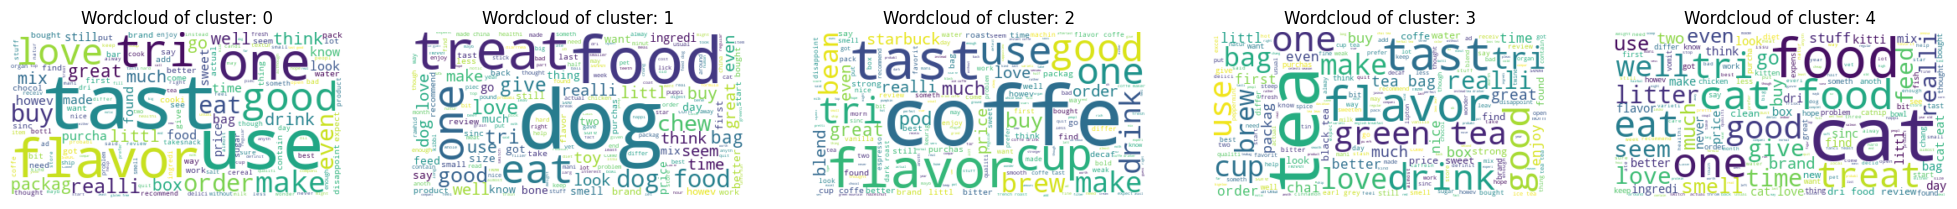

In [ ]:
# visualizing clustering words
display_cluster_wordcloud([X_train[:15000], hc.labels_], hc.n_clusters, ncols = 5)

<p align='justify'>
Also by using hierarchical clustering we do not optain good results. Clustering seems as the previouse one.
</p>

## K-means on best k
<p align='justify'>
As a final test we try to find the optimal number of clusters by maximizing the silhouette metric. The goal is to form clusters that divide the content of the reviews. <br>

You can check the [yellowbrick documentation](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) for an explanation on the implementation of the elbow method 
</p>

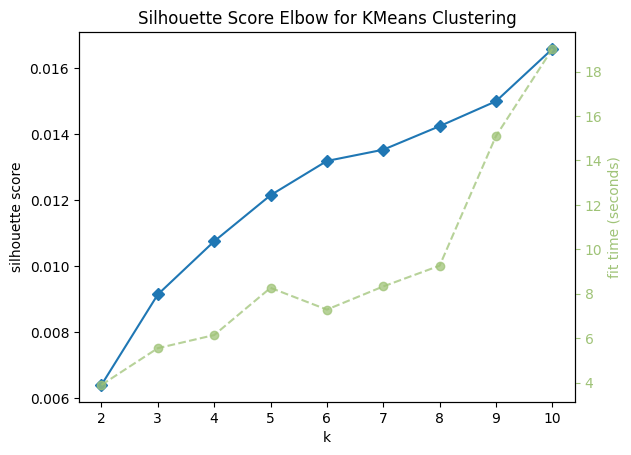

In [ ]:
# Instantiate the clustering model and visualizer. We want to plot the silhouette score
# for k = 2 to k = 10.
model = KMeans()
visualizer_ch = KElbowVisualizer(
    model, k=(2,11), metric='silhouette', locate_elbow = False
)

# Fit the data to the visualizer
visualizer_ch.fit(standardized_data_train[0:5000])
# Finalize and render the figure       
visualizer_ch.show()        

<p align='justify'>
From the graph we can easily see that for k equal to $10$ the silhouette value is maximized, even if it remains very small and close to zero, a sign that indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
</p>

In [ ]:
# setting up kmeans with k = 10. We use standardize features
kmeans2 = KMeans(n_clusters=10, random_state=39).fit(standardized_data_train[:5000])

In [ ]:
# counting element per list
c = Counter(kmeans2.labels_)

for i in range(0,10, 1):
  print('No. of reviews in Cluster-' + str(i) + ': ' + str(c[i]))

No. of reviews in Cluster-0: 252
No. of reviews in Cluster-1: 949
No. of reviews in Cluster-2: 132
No. of reviews in Cluster-3: 365
No. of reviews in Cluster-4: 446
No. of reviews in Cluster-5: 1849
No. of reviews in Cluster-6: 273
No. of reviews in Cluster-7: 374
No. of reviews in Cluster-8: 235
No. of reviews in Cluster-9: 125


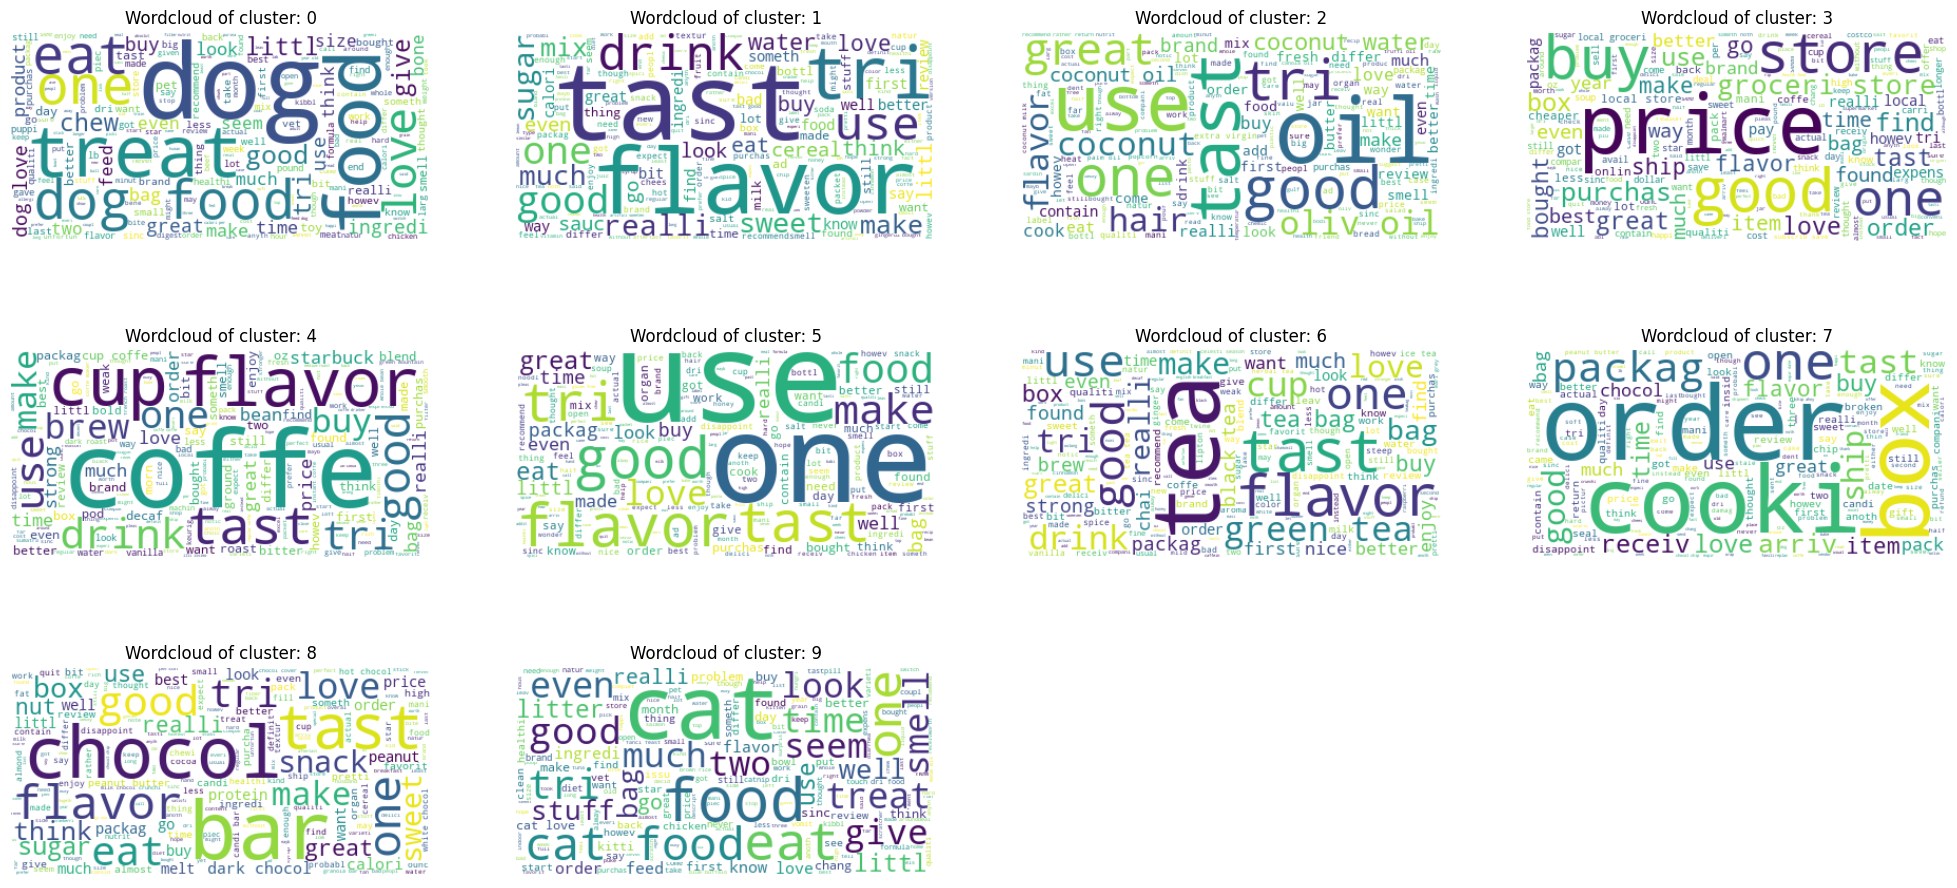

In [ ]:
# visualizing clustering words
display_cluster_wordcloud([X_train[:5000], kmeans2.labels_], kmeans2.n_clusters)

<p align='justify'>
From the wordcloud we can see that there seems to be a rough subdivision. For example, cluster $8$ seems to talk about chocolate/snacks/sugar, cluster $6$ talk about tea, etc ... However, some clusters seem to report the same themes such as cluster $3$ and $7$. Given that the silhouette index was close at zero this was expected, as we already knew at the start that the clusters could not be well separated from each other. 
</p>

# Topic modeling
<p align='justify'>
As an additional task we tried to carry out Topic Modeling by applying LDA (Latend Dirichlet Allocation). This is unsupervised learning, because it automatically groups words without a predefined list of labels.
The presence of at least $5$ topics had already emerged from the previous clustering: animals, coffee, tea, orders, chocolate/snacks.
</p>

In [ ]:
# saving fitted tf-idf
vect_tfidf = TfidfVectorizer(max_features = 1500, min_df = 10, max_df = 0.5).fit(X_train.astype(str))
# apply it on training set
X_train_tfidf = vect_tfidf.transform(X_train.astype(str))

<p align='justify'>
We therefore searched for a number of topics $\geq 5$ that would minimize the perplexity metric, this minimization confirmed that the optimal choice for the extraction of topics is to keep $5$ different components.
</p>

In [ ]:
# searching for best number of components by minimize perplexity score
for i in [5,7,10,13]:
  lda_tf = LatentDirichletAllocation(n_components=i, random_state=0)
  lda_tf.fit(X_train_tfidf)
  print('LDA on', i, 'components. Perplexity:', lda_tf.perplexity(X_train_tfidf))

LDA on 5 components. Perplexity: 1455.3005194207763
LDA on 7 components. Perplexity: 1573.746661481364
LDA on 10 components. Perplexity: 1747.2873473879056
LDA on 13 components. Perplexity: 1888.9244794426943


<p align='justify'>
he results in this case are much better, already using the pyLDAvis library that allows you to graphically view the topics you can see that the $5$ topics are far from each other.
</p>

In [ ]:
# apply sklearn LDA on training set
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(X_train_tfidf)
# visualize results with pyLDAvis library
pyLDAvis.sklearn.prepare(lda_tf, X_train_tfidf, vect_tfidf, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  26.880184
1       51.163364 -159.968018       2        1  20.072812
0      -73.144554   21.523815       3        1  19.974762
4      -66.410133 -110.606438       4        1  19.113638
3       54.417324   12.443444       5        1  13.958604, topic_info=        Term         Freq        Total Category  logprob  loglift
254    coffe  2679.000000  2679.000000  Default  30.0000  30.0000
1322     tea  2226.000000  2226.000000  Default  29.0000  29.0000
379      dog  1325.000000  1325.000000  Default  28.0000  28.0000
320      cup  1296.000000  1296.000000  Default  27.0000  27.0000
393    drink  1299.000000  1299.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1010   price   260.270262  1466.980052   Topic5  -5.2961   0.2398
176      buy   264.775552  1699.473009   Topic5  -5.2790   0.1099
148    brand   241.165302   976.860320   Topic5  -5.3724   0.5702
776     make   242.100478  1498.740663   Topic5  -5.3685   0.1460
115   better   237.499470  1229.652773   Topic5  -5.3877   0.3248

[354 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
18        1  0.161028  aftertast
18        2  0.027870  aftertast
18        4  0.579083  aftertast
18        5  0.229156  aftertast
30        1  0.827504     almond
...     ...       ...        ...
1491      1  0.176748       year
1491      2  0.197240       year
1491      3  0.384234       year
1491      4  0.130640       year
1491      5  0.111428       year

[935 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

<p align='justify'>
By default topics are marked with a number and not with the argument, so it is necessary to inspect the words contained in each one to manually assign the reference argument. By looking for each circle in the visualization proposed above with $\lambda = 1$ you can see that all topics are interpretable and even if there are words repeated or slightly out of context, it is possible to understand well the probable argument covered by each topic. About this topic $1$ talks about general flavor and sweets, topic $2$ is about the order and shipping process, topic $3$ is for animals, topic $4$ for tea and topic $5$ talks about coffee. This interpretation remains valid also if you decrease the $\lambda$ to include also more rare words. As said before this is not perfect but seems to be quite reasonable as results.
</p>